In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import *

In [7]:
def set_behavior_path(sub, behavestring):
    extra='recogarray.txt'
    behaveobj=[behavestring+sub+extra]
    behavepath=Path(behaveobj[0])
    behavepath.exists()
    return behavepath

def set_times_path(sub, behavestring):
    timesarrayextra='refreshtimes.txt'
    timesarrayobj=[behavestring+sub+timesarrayextra]
    timesarray_path=Path(timesarrayobj[0])
    timesarray_path.exists()
    return timesarray_path


def get_refresh_all(subids,pathstring):

    eyepath=Path(pathstring)
    if not eyepath.exists():
        print("can't find path, check connection!!")
        quit()

    #TODO: get the other files later
    masternames=get_eye_files(subids,eyepath)
    # study_all=masternames[masternames['phase']=="a"]
    refresh_all=masternames[masternames['phase']=="b"]
    # recog_all=masternames[masternames['phase']=="c"]
    return refresh_all

def load_data_for_subject(sub, refresh_all, pathstring, behavestring, is_pres=True):
    refresh_sub=[]
    refresh_sub=refresh_all[refresh_all['subject']==sub]
    eyearray = read_in_eye_data(refresh_sub,pathstring)
    if not len(eyearray):
        print('eyearray is empty!')


    behavepath = set_behavior_path(sub, behavestring)
    timesarray_path = set_times_path(sub, behavestring)

    behavearray=read_behave_file(behavepath)
    print('len(behavearray)', len(behavearray))
    #apply coordinate change to behavioral data if True in subdict
    if is_pres:
        behavearray=apply_adjust_pres_coords(behavearray)
        timesarray=read_times_file_pres(timesarray_path)
    else:
        timesarray=read_times_file_mat(timesarray_path)

    print('len(timesarray)', len(timesarray))
    return eyearray,behavearray,timesarray


In [8]:
def parse_eye_filename(pathobject):
    fname=pathobject.name
    parts=fname.split(".")[0]
    subject=parts[:5]
    other=parts[5:]
    has_r="r" in other
    if has_r:
        other=other.replace("r","")
    try:
        block=int(other[0])
        phase=other[1]
    except:
        block=int(other[1])
        phase=other[0]
    subdict={"subject":subject, "phase":phase,"block":block, "fname":fname}
    return subdict



def get_eye_files(subids,eyepath):
    """ returns master dataframe including eye file name, block, phase, subid
    input list of subject strings, Path object pointing to eye files
    """
    print(subids)
    substrings=[s+"*.asc" for s in subids]
    subinfo=[]
    for s in substrings:
        for filepathobj in eyepath.glob(s):
            subdict=parse_eye_filename(filepathobj)
            subinfo.append(subdict)

    masterdf=pd.DataFrame(subinfo).sort_values(by=["subject","phase","block"])
    print(masterdf.head())
    masterdf=masterdf[["subject","phase","block","fname"]]
    masterdf.index=range(len(masterdf))
    return masterdf


def parse_eye_events_to_intline(line,extrainfo):
    efixspace=["","",""]
    eblinkspace=efixspace*2
    newline=line.split()
    if "EFIX" in line:
        newline.extend(efixspace)
    elif "EBLINK" in line:
        newline.extend(eblinkspace)
    newline.extend(extrainfo)
    return newline


def parse_eye_line(phase_sub,pathstring):
    """ parses each line of eye file for a given phase_sub
    input one phase type list of files for a subs
    and the path to the file (in form of a string)
    outputs dataframe with all events in table
    """
    etypes=('ESACC','EFIX','EBLINK')
    events=[]
    blocks=phase_sub.block
    fnames=phase_sub.fname
    subjects=phase_sub.subject
    trialnum=0

    for block,fname,subject in zip(blocks,fnames,subjects):
        path_file=pathstring+fname
        p=Path(path_file)
        with p.open() as f:
            for line in f:
                if "START" in line:
                    trialnum=trialnum+1
                    startline=line.split()
                    starttime=int(startline[1])
                if any(e in line for e in etypes):
                    extrainfo=[starttime,trialnum,block,subject]
                    newline=parse_eye_events_to_intline(line,extrainfo)
                    events.append(newline)
            print(trialnum, block)    
    return events

def events_to_df(events):
    """ change raw events to data DataFrame
    then and change values to numeric"""

    eye_events_df=pd.DataFrame(events)
    eye_events_df=eye_events_df.apply(pd.to_numeric,errors='ignore')
    headers=["event","eye","start","end","duration",
    "xstart","ystart","xend","yend","?","?","trialstart",
    "trialnum","block","sub"]
    eye_events_df.columns=headers
    return eye_events_df

def eventsdf_cleanup(eye_events_df):
    """adjust trial start time, remove irrelevant values in fixation rows,
    and then delete excess columns"""

    eyedf_clean=eye_events_df.copy()

    eyedf_clean['start']=eyedf_clean['start']-eyedf_clean['trialstart']
    eyedf_clean['end']=eyedf_clean['end']-eyedf_clean['trialstart']

    efix_mask = (eyedf_clean["event"]=="EFIX")
    eyedf_clean.loc[efix_mask, 'xend'] = np.nan

    del eyedf_clean['trialstart']
    del eyedf_clean['?']
    del eyedf_clean['eye']

    return eyedf_clean

def read_in_eye_data(refresh_sub,pathstring):
    eye_events=parse_eye_line(refresh_sub,pathstring)
    eyedf=events_to_df(eye_events)
    eyearray=eventsdf_cleanup(eyedf)
    return eyearray

In [9]:
def read_behave_file(filepath):
    """read in behavearray, turn into DataFrame and delete extra columns"""
    colnames=['loc1x','loc1y','tmpx','tmpy','tmpdist','tmpmaxdist','tmpdistused','block','angle','loc3x','loc3y','loc2x','loc2y',
         'loc1-loc2dist','loc1-loc3dist','loc2-loc3dist','picid','contextid','cond',
         'study order','refresh order','recog order','same/diff','same/diff rt',
          'recog button', 'recog loc','recog rt','tmp']
    behavearray=pd.read_table(filepath,header=None,names=colnames)
    tmpmask=~behavearray.columns.str.contains('tmp')
    behavearray=behavearray[behavearray.columns[tmpmask]]
    return behavearray


def adjust_pres_coords(array,x,y,xmax=1920/2,ymax=1080/2):
    """adjustment for behavioral coords to match
    eye coords for presentation version of exp"""
    newarray=pd.DataFrame()
    newarray[x]=array[x]+xmax
    newarray[y]=(array[y]-ymax)*-1
    return newarray

def apply_adjust_pres_coords(behavearray):
    """applies adjust_pres_coords to all
    coords in behave array"""
    newloc1=adjust_pres_coords(behavearray,'loc1x','loc1y')
    newloc2=adjust_pres_coords(behavearray,'loc2x','loc2y')
    newloc3=adjust_pres_coords(behavearray,'loc3x','loc3y')
    newlocs=pd.concat([newloc1,newloc2,newloc3],axis=1)

    cols=newlocs.columns.tolist()
    for loc in cols:
        behavearray[loc]=newlocs[loc]
    return behavearray

def read_times_file_pres(timespath):
    timecolnames=['global trial start','objonset','trialend']
    timesdf=pd.read_table(timespath,header=None, names=timecolnames, index_col=False)
    print(timesdf.head())
    del timesdf['global trial start']
    return timesdf

def read_times_file_mat(timespath):
    print('running',timespath)
    timecolnames=['tmp1', 'tmp2', 'objonset','tmp3', 'tmp4']
    timesdf=pd.read_table(timespath,header=None,names=timecolnames, index_col=False)
    print(timesdf.head())
    to_delete=['tmp1', 'tmp2', 'tmp3', 'tmp4']
    for tmp in to_delete:
        del timesdf[tmp]
    timesdf['trialend']=np.nan
    return timesdf

In [10]:
def run_all():
    # subids=["ec105","ec106","ec107","ec108"]
    subids=["ec108"]
    matlab_subs = ["ec105", "ec106"]
    pathstring='/Volumes/Voss_Lab/ECOG/ecog/locationspace/ecog.eye/'
    behavestring='/Volumes/Voss_Lab/ECOG/ecog/locationspace/ecog.behave/'

    refresh_all = get_refresh_all(subids,pathstring)

    for sub in subids:
        is_pres = (sub not in matlab_subs)
        print('running', sub, 'using presentation', is_pres)
        output=load_data_for_subject(sub, refresh_all, pathstring, behavestring, is_pres)
    return output
eyearray,behavearray,timesarray=run_all()
#         preprocess_subject_dfs(sub, *output)
#         print(sub, 'is done!')

['ec108']
    block         fname phase subject
19      1  ec108ar1.asc     a   ec108
22      2  ec108ar2.asc     a   ec108
16      3  ec108ar3.asc     a   ec108
23      4  ec108ar4.asc     a   ec108
1       5  ec108ar5.asc     a   ec108
running ec108 using presentation True
16 1
32 2
48 3
64 4
80 5
96 6
112 7
128 8
len(behavearray) 128
   global trial start  objonset  trialend
0              280547      2033      8703
1              289349      2033      8503
2              297955      2030      9268
3              307325      2029      8398
4              315823      2034      8372
len(timesarray) 128


In [11]:
behavearray.sort_values(by=['refresh order'], inplace=True)
behavearray

,loc1x,loc1y,block,angle,loc3x,loc3y,loc2x,loc2y,loc1-loc2dist,loc1-loc3dist,...,contextid,cond,study order,refresh order,recog order,same/diff,same/diff rt,recog button,recog loc,recog rt
9,537.0,943.0,1,60,239.0,277.0,964.0,352.0,730,730,...,7,1,16,1,10,2,81,7,1,25
12,1201.0,155.0,1,-60,1461.0,622.0,1736.0,164.0,536,536,...,7,2,1,2,13,1,70,6,1,26
6,423.0,281.0,1,60,375.0,595.0,126.0,396.0,319,319,...,7,1,13,3,7,3,115,8,1,46
0,1542.0,737.0,1,60,897.0,957.0,1028.0,288.0,683,683,...,7,2,7,4,1,1,63,8,1,26
7,841.0,778.0,1,60,1182.0,123.0,1578.0,746.0,738,738,...,7,1,6,5,8,2,61,6,1,26
14,592.0,500.0,1,-60,841.0,945.0,1102.0,508.0,511,511,...,7,2,4,6,15,1,100,6,1,29
8,1078.0,672.0,1,-60,1539.0,945.0,1545.0,410.0,536,536,...,7,1,14,7,9,3,88,6,1,32
1,625.0,946.0,1,60,301.0,684.0,689.0,534.0,417,417,...,7,1,10,8,2,2,68,7,1,58
5,113.0,435.0,1,60,771.0,128.0,707.0,851.0,726,726,...,7,2,2,9,6,1,55,6,1,36
13,700.0,394.0,1,60,809.0,892.0,322.0,737.0,511,511,...,7,1,8,10,14,1,90,7,1,33


In [13]:
# def eye_behave_combo(eyearray,behavearray,timesarray):
eyebehave=eyearray.copy()
behavearray.sort_values(by=['refresh order'], inplace=True)
eyecols=eyebehave.columns.tolist()
behavecols=['loc1x','loc1y','loc2x','loc2y','loc3x','loc3y','recog loc','same/diff','cond', 'refresh order']
allcols=eyecols+behavecols+['objonset','trialend']
eyebehave=eyebehave.reindex(columns=allcols)

In [14]:
behavearray.shape

(128, 22)

In [15]:
 for trial,col in enumerate(behavearray):
        eyetrialevents=(eyebehave['trialnum']==trial+1)
        eyetrial=eyebehave.loc[eyetrialevents]

        behtrialevents=(behavearray['refresh order']==trial+1)
        behtrial=behavearray.loc[behtrialevents]
        for col in behavecols:
            eyetrial.loc[eyetrialevents,col]=behtrial.iloc[0][col]

        objonsetmask=timesarray.index==trial
        onsettrial=timesarray.loc[objonsetmask]
        eyetrial.loc[eyetrialevents,'objonset']=onsettrial.iloc[0]['objonset']
        eyetrial.loc[eyetrialevents,'trialend']=onsettrial.iloc[0]['trialend']

        eyebehave.loc[eyetrialevents]=eyetrial
eyebehave

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,start,end,duration,xstart,ystart,xend,yend,trialnum,block,...,loc2x,loc2y,loc3x,loc3y,recog loc,same/diff,cond,refresh order,objonset,trialend
0,EFIX,4,260,258,847.5,445.9,NaN,NaN,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
1,ESACC,262,296,36,845.6,447.5,656.1,609.3,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
2,EFIX,298,614,318,653.2,625.9,NaN,NaN,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
3,ESACC,616,650,36,661.0,634.3,860.7,491.1,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
4,EFIX,652,788,138,862.3,488.1,NaN,NaN,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
5,ESACC,790,814,26,865.1,488.4,995.5,401.1,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
6,EFIX,816,1110,296,1017.2,381.5,NaN,NaN,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
7,ESACC,1112,1158,48,1016.4,373.2,549.4,303.5,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
8,EFIX,1160,1488,330,538.3,307.6,NaN,NaN,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0
9,ESACC,1490,1552,64,538.9,316.0,1251.9,498.6,1,1,...,964.0,352.0,239.0,277.0,1.0,2.0,1.0,1.0,2033.0,8703.0


In [142]:
sublist=['ec105', 'ec106', 'ec107', 'ec108']
all=pd.DataFrame()
for sub in sublist:
    file='data/' + sub + 'eyebehave.csv'
    print(file)
    eye=pd.read_csv(file, index_col=0)
    all=pd.concat([all,eye])
all.columns

data/ec105eyebehave.csv
data/ec106eyebehave.csv
data/ec107eyebehave.csv
data/ec108eyebehave.csv


Index(['block', 'cond', 'duration', 'end', 'endloc', 'event', 'loc1end',
       'loc1start', 'loc1x', 'loc1y', 'loc2end', 'loc2start', 'loc2x', 'loc2y',
       'loc3end', 'loc3start', 'loc3x', 'loc3y', 'objonset', 'recog loc',
       'same/diff', 'start', 'startloc', 'sub', 'trialend', 'trialnum', 'xend',
       'xstart', 'yend', 'ystart'],
      dtype='object')

In [146]:
sub='ec106'
subdf=all[(all['sub']==sub)]
subdf
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(subdf.xstart, subdf.ystart, marker='.', alpha=0.3)
# ax.plot(subdf.xstart, subdf.ystart, marker='.', alpha=0.3)
# ax.scatter(subdf.loc1x, subdf.loc1y, marker='*', c='cyan')
# ax.scatter(subdf.loc2x, subdf.loc2y, marker='*', c='red')
# ax.scatter(subdf.loc3x, subdf.loc3y, marker='*', c='green')
# plt.xlim(0, 1920)
# plt.ylim(0, 1080)

,block,cond,duration,end,endloc,event,loc1end,loc1start,loc1x,loc1y,...,same/diff,start,startloc,sub,trialend,trialnum,xend,xstart,yend,ystart
0,1,2.0,16,324.624,loc3end,ESACC,556.523000,538.524521,1431.0,263.0,...,-1.0,310.624,loc3start,ec106,NaN,1,945.7,988.9,535.4,570.5
1,1,2.0,92,416.624,NaN,EFIX,NaN,560.249462,1431.0,263.0,...,-1.0,326.624,loc3start,ec106,NaN,1,NaN,939.5,NaN,531.9
2,1,2.0,50,466.624,loc1end,ESACC,67.710339,556.787329,1431.0,263.0,...,-1.0,418.624,loc3start,ec106,NaN,1,1381.5,937.7,309.2,521.2
3,1,2.0,136,602.624,NaN,EFIX,NaN,75.743052,1431.0,263.0,...,-1.0,468.624,loc1start,ec106,NaN,1,NaN,1376.5,NaN,315.6
4,1,2.0,18,620.624,loc1end,ESACC,33.988969,73.373633,1431.0,263.0,...,-1.0,604.624,loc1start,ec106,NaN,1,1446.0,1381.0,293.5,316.7
5,1,2.0,1232,1852.624,NaN,EFIX,NaN,29.121985,1431.0,263.0,...,-1.0,622.624,loc1start,ec106,NaN,1,NaN,1454.5,NaN,280.2
6,1,2.0,56,1908.624,loc2end,ESACC,530.219766,25.932605,1431.0,263.0,...,-1.0,1854.624,loc1start,ec106,NaN,1,1338.0,1445.5,785.0,284.5
7,1,2.0,182,2090.624,NaN,EFIX,NaN,545.723923,1431.0,263.0,...,-1.0,1910.624,loc2start,ec106,NaN,1,NaN,1327.4,NaN,798.8
8,1,2.0,24,2114.624,loc2end,ESACC,614.046464,552.893426,1431.0,263.0,...,-1.0,2092.624,loc2start,ec106,NaN,1,1405.1,1324.3,876.5,805.5
9,1,2.0,308,2422.624,NaN,EFIX,NaN,630.501269,1431.0,263.0,...,-1.0,2116.624,loc2start,ec106,NaN,1,NaN,1397.3,NaN,892.6


(0, 1080)

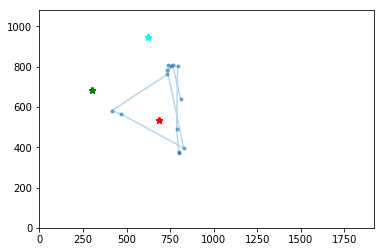

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ec108.xstart, ec108.ystart, marker='.', alpha=0.3)
ax.plot(ec108.xstart, ec108.ystart, marker='.', alpha=0.3)
ax.scatter(ec108.loc1x, ec108.loc1y, marker='*', c='cyan')
ax.scatter(ec108.loc2x, ec108.loc2y, marker='*', c='red')
ax.scatter(ec108.loc3x, ec108.loc3y, marker='*', c='green')
plt.xlim(0, 1920)
plt.ylim(0, 1080)

In [7]:
locs=['loc1start', 'loc2start', 'loc3start', 'screen']
for conds, ldf in all.groupby(['sub', 'block', 'trialnum', 'cond']):
    print(ldf)

    block  cond  duration       end     endloc  event      loc1end  \
21      1   1.0        30  4797.844        NaN  blink          NaN   
23      1   1.0       250  5047.844  offscreen  ESACC  5431.482302   

     loc1start  loc1x  loc1y   ...    same/diff     start   startloc    sub  \
21  408.830539  640.0  500.0   ...         -1.0  4769.844  loc3start  ec105   
23  419.653726  640.0  500.0   ...         -1.0  4799.844  loc3start  ec105   

    trialend  trialnum    xend  xstart    yend  ystart  
21       NaN         1     NaN   280.4     NaN   305.5  
23       NaN         1 -3270.0   270.1 -3270.0   301.8  

[2 rows x 30 columns]
   block  cond  duration       end     endloc  event      loc1end  \
1      1   1.0        36  1421.844        NaN   EFIX          NaN   
2      1   1.0        30  1451.844  offscreen  ESACC  2166.379782   
3      1   1.0        32  1483.844        NaN  blink          NaN   
5      1   1.0      1094  2577.844     screen  ESACC   480.432482   

     loc1st

    block  cond  duration       end   endloc  event    loc1end   loc1start  \
46      1   1.0      3334  3570.338      NaN   EFIX        NaN  447.800011   
47      1   1.0        58  3628.338  loc1end  ESACC  15.439236  428.725973   
50      1   1.0       958  5046.338      NaN   EFIX        NaN  446.366677   

    loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
46  347.0  396.0   ...          2.0   238.338  loc2start  ec105       NaN   
47  347.0  396.0   ...          2.0  3572.338  loc2start  ec105       NaN   
50  347.0  396.0   ...          2.0  4090.338  loc2start  ec105       NaN   

    trialnum   xend  xstart   yend  ystart  
46         6    NaN   783.9    NaN   297.8  
47         6  348.1   761.0  380.6   284.6  
50         6    NaN   780.5    NaN   289.6  

[3 rows x 30 columns]
    block  cond  duration      end   endloc  event     loc1end   loc1start  \
45      1   1.0        30  236.338  loc2end  ESACC  443.440064  601.603898   

    loc1x  loc1y  

    block  cond  duration       end     endloc  event      loc1end  \
77      1   2.0        60  1480.933        NaN   EFIX          NaN   
78      1   2.0       510  1990.933  offscreen  ESACC  1706.790262   
79      1   2.0        46  2036.933        NaN  blink          NaN   
81      1   2.0       642  2678.933    loc3end  ESACC   513.050972   

      loc1start  loc1x  loc1y   ...    same/diff     start   startloc    sub  \
77  1804.942354  343.0  385.0   ...          2.0  1422.933  offscreen  ec105   
78  1819.439787  343.0  385.0   ...          2.0  1482.933  offscreen  ec105   
79  1798.126205  343.0  385.0   ...          2.0  1992.933  offscreen  ec105   
81  1887.463960  343.0  385.0   ...          2.0  2038.933  offscreen  ec105   

    trialend  trialnum    xend  xstart   yend  ystart  
77       NaN         9     NaN -1440.7    NaN   108.9  
78       NaN         9 -1355.0 -1454.5  212.0   103.3  
79       NaN         9     NaN -1445.8    NaN   202.1  
81       NaN         9  

     block  cond  duration       end   endloc  event    loc1end   loc1start  \
130      1   1.0       264  2648.385      NaN   EFIX        NaN  238.771962   
131      1   1.0        36  2684.385  loc1end  ESACC  72.000625  234.190734   

     loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
130  329.0  284.0   ...          2.0  2386.385    screen  ec105       NaN   
131  329.0  284.0   ...          2.0  2650.385    screen  ec105       NaN   

     trialnum   xend  xstart   yend  ystart  
130        12    NaN   409.2    NaN   508.9  
131        12  257.0   410.1  283.7   503.7  

[2 rows x 30 columns]
     block  cond  duration       end   endloc  event     loc1end   loc1start  \
136      1   1.0        42   324.622      NaN   EFIX         NaN   63.763077   
137      1   1.0        38   362.622  loc1end  ESACC   45.393061   55.879334   
138      1   1.0        24   386.622      NaN   EFIX         NaN   47.624888   
139      1   1.0        42   428.622  loc2end  ES

     block  cond  duration      end   endloc  event     loc1end   loc1start  \
159      1   1.0        36  253.563   screen  ESACC  266.765702  560.827959   
160      1   1.0       126  379.563      NaN   EFIX         NaN  281.748718   
161      1   1.0        24  403.563  loc2end  ESACC  344.044096  282.931882   

      loc1x  loc1y   ...    same/diff    start  startloc    sub  trialend  \
159  1491.0  364.0   ...          2.0  219.563    screen  ec105       NaN   
160  1491.0  364.0   ...          2.0  255.563    screen  ec105       NaN   
161  1491.0  364.0   ...          2.0  381.563    screen  ec105       NaN   

     trialnum    xend  xstart   yend  ystart  
159        15  1394.5   954.2  612.7   526.4  
160        15     NaN  1411.5    NaN   634.3  
161        15  1545.5  1415.6  703.7   636.7  

[3 rows x 30 columns]
     block  cond  duration      end   endloc  event     loc1end   loc1start  \
177      1   1.0        34   247.39  loc2end  ESACC  419.242519  130.245921   
189  

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
256      2   2.0       622   848.214      NaN   EFIX         NaN  175.949567   
257      2   2.0        12   860.214  loc1end  ESACC  146.011849  166.124923   
258      2   2.0       194  1054.214      NaN   EFIX         NaN  150.522457   
259      2   2.0        42  1096.214   screen  ESACC  235.849889  131.608548   
269      2   2.0        14  2594.214  loc1end  ESACC  133.799589  169.191637   
270      2   2.0       188  2782.214      NaN   EFIX         NaN  111.416785   
271      2   2.0        14  2796.214  loc1end  ESACC  117.253614   90.844152   
272      2   2.0        96  2892.214      NaN   EFIX         NaN  115.999741   
273      2   2.0        60  2952.214  loc1end  ESACC   88.705411  113.804438   
274      2   2.0       208  3160.214      NaN   EFIX         NaN  124.126146   
275      2   2.0        14  3174.214  loc1end  ESACC  167.100269  136.432731   
277      2   2.0        10  4122.214  lo

[3 rows x 30 columns]
     block  cond  duration       end     endloc  event      loc1end  \
376      2   2.0        64  3551.202        NaN   EFIX          NaN   
377      2   2.0        16  3567.202  offscreen  ESACC  1097.702920   
378      2   2.0       108  3675.202        NaN   EFIX          NaN   
380      2   2.0       878  4553.202    loc1end  ESACC   111.558057   

       loc1start   loc1x  loc1y   ...    same/diff     start   startloc  \
376  1178.574703  1131.0  720.0   ...          3.0  3489.202  offscreen   
377  1182.139349  1131.0  720.0   ...          3.0  3553.202  offscreen   
378  1163.479368  1131.0  720.0   ...          3.0  3569.202  offscreen   
380  1216.130343  1131.0  720.0   ...          3.0  3677.202  offscreen   

       sub  trialend  trialnum    xend  xstart    yend  ystart  
376  ec105       NaN         8     NaN  1899.8     NaN  1613.3  
377  ec105       NaN         8  1836.1  1887.0  1561.3  1628.8  
378  ec105       NaN         8     NaN  1879.2     

     block  cond  duration       end  endloc  event      loc1end    loc1start  \
463      2   1.0       182   432.385     NaN   EFIX          NaN   888.937146   
464      2   1.0        12   444.385  screen  ESACC   894.360252   892.667430   
465      2   1.0       234   678.385     NaN   EFIX          NaN   914.786194   
466      2   1.0        12   690.385  screen  ESACC   920.982530   923.236638   
467      2   1.0       206   896.385     NaN   EFIX          NaN   910.677638   
468      2   1.0        54   950.385  screen  ESACC  1086.962980   910.840601   
469      2   1.0        64  1014.385     NaN   EFIX          NaN  1113.449703   
470      2   1.0        22  1036.385  screen  ESACC   984.222277  1107.823221   
471      2   1.0        28  1064.385     NaN   EFIX          NaN   983.817971   
472      2   1.0        10  1074.385  screen  ESACC  1099.598950   979.828036   
473      2   1.0        40  1114.385     NaN   EFIX          NaN  1105.883561   
474      2   1.0        98  

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
630      3   2.0      1288  1528.385      NaN   EFIX         NaN  379.435858   
632      3   2.0       404  1932.385   screen  ESACC  593.204223  374.988600   
635      3   2.0       456  2436.385      NaN   EFIX         NaN  414.817189   
637      3   2.0       292  2728.385  loc2end  ESACC  426.312374  416.494058   
638      3   2.0      1736  4464.385      NaN   EFIX         NaN  335.347477   
639      3   2.0        14  4478.385  loc2end  ESACC  354.887503  321.603809   
640      3   2.0       568  5046.385      NaN   EFIX         NaN  362.003439   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
630  1553.0  521.0   ...          1.0   242.385  loc2start  ec105       NaN   
632  1553.0  521.0   ...          1.0  1530.385  loc2start  ec105       NaN   
635  1553.0  521.0   ...          1.0  1982.385  loc2start  ec105       NaN   
637  1553.0  521.0   ...          1.0  2438

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
696      3   2.0      1702  1927.202      NaN   EFIX         NaN  166.029666   
697      3   2.0        16  1943.202  loc1end  ESACC  145.671411  134.431284   
701      3   2.0        30  2177.202  loc2end  ESACC  440.563662  178.548845   
704      3   2.0      1266  4045.202      NaN   EFIX         NaN  162.676120   
705      3   2.0        40  4085.202   screen  ESACC  494.872963  163.840319   
708      3   2.0       358  5043.202      NaN   EFIX         NaN  158.320592   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
696  1131.0  720.0   ...          3.0   227.202  loc1start  ec105       NaN   
697  1131.0  720.0   ...          3.0  1929.202  loc1start  ec105       NaN   
701  1131.0  720.0   ...          3.0  2149.202  loc1start  ec105       NaN   
704  1131.0  720.0   ...          3.0  2781.202  loc1start  ec105       NaN   
705  1131.0  720.0   ...          3.0  4047.

     block  cond  duration       end  endloc  event     loc1end   loc1start  \
751      3   1.0        24   222.622  screen  ESACC  615.254655  431.963251   
752      3   1.0       114   336.622     NaN   EFIX         NaN  647.040532   
753      3   1.0        28   364.622  screen  ESACC  905.086565  647.085473   
754      3   1.0       634   998.622     NaN   EFIX         NaN  990.940180   
755      3   1.0        42  1040.622  screen  ESACC  676.723769  991.401200   
756      3   1.0       370  1410.622     NaN   EFIX         NaN  611.168365   
757      3   1.0        40  1450.622  screen  ESACC  770.617837  610.399492   
758      3   1.0       420  1870.622     NaN   EFIX         NaN  784.744729   
759      3   1.0        40  1910.622  screen  ESACC  916.426893  801.510206   
760      3   1.0       164  2074.622     NaN   EFIX         NaN  944.336937   
761      3   1.0        20  2094.622  screen  ESACC  991.892595  946.064633   
762      3   1.0      2948  5042.622     NaN   EFIX 

     block  cond  duration       end  endloc  event      loc1end    loc1start  \
832      4   2.0        34   248.214  screen  ESACC   753.627182   443.220318   
833      4   2.0       638   886.214     NaN   EFIX          NaN   818.431701   
834      4   2.0        20   906.214  screen  ESACC   808.505393   854.260879   
835      4   2.0        80   986.214     NaN   EFIX          NaN   811.271952   
836      4   2.0        12   998.214  screen  ESACC   807.029076   828.097627   
837      4   2.0       484  1482.214     NaN   EFIX          NaN   823.570477   
838      4   2.0        36  1518.214  screen  ESACC  1142.747063   888.997576   
839      4   2.0       468  1986.214     NaN   EFIX          NaN  1163.184706   
840      4   2.0        38  2024.214  screen  ESACC   813.716959  1143.591837   
841      4   2.0      2282  4306.214     NaN   EFIX          NaN   818.468869   
842      4   2.0        10  4316.214  screen  ESACC   820.146481   838.812422   
843      4   2.0       198  

     block  cond  duration       end   endloc  event    loc1end   loc1start  \
921      4   2.0       628  1726.933      NaN   EFIX        NaN  503.770285   
922      4   2.0        50  1776.933  loc1end  ESACC  78.829753  511.412260   

     loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
921  343.0  385.0   ...          2.0  1100.933  loc2start  ec105       NaN   
922  343.0  385.0   ...          2.0  1728.933  loc2start  ec105       NaN   

     trialnum   xend  xstart   yend  ystart  
921         9    NaN   843.9    NaN   331.3  
922         9  355.7   851.5  307.2   330.5  

[2 rows x 30 columns]
     block  cond  duration      end   endloc  event     loc1end  loc1start  \
916      4   2.0        36  246.933  loc1end  ESACC  145.381223  643.50411   

     loc1x  loc1y   ...    same/diff    start  startloc    sub  trialend  \
916  343.0  385.0   ...          2.0  212.933    screen  ec105       NaN   

     trialnum   xend  xstart   yend  ystart  
916       

      block  cond  duration       end     endloc  event      loc1end  \
1049      4   2.0       134  3094.397        NaN   EFIX          NaN   
1051      4   2.0       678  3772.397     screen  ESACC   697.156008   
1052      4   2.0        40  3812.397        NaN  blink          NaN   
1055      4   2.0        60  4398.397        NaN   EFIX          NaN   
1056      4   2.0        50  4448.397  offscreen  ESACC  1904.280468   
1057      4   2.0        32  4480.397        NaN   EFIX          NaN   
1058      4   2.0        42  4522.397  offscreen  ESACC  1859.957317   
1059      4   2.0        30  4552.397        NaN   EFIX          NaN   
1060      4   2.0       180  4732.397  offscreen  ESACC  1866.220258   
1061      4   2.0        22  4754.397        NaN   EFIX          NaN   
1062      4   2.0        82  4836.397  offscreen  ESACC  1892.838580   
1063      4   2.0        54  4890.397        NaN   EFIX          NaN   
1064      4   2.0       152  5042.397     screen  ESACC   909.86

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1108      5   2.0        40   226.787  loc2end  ESACC  472.854840  211.671302   
1111      5   2.0       840  1618.787      NaN   EFIX         NaN  473.465289   
1112      5   2.0        24  1642.787  loc2end  ESACC  448.467936  464.075253   

       loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1108  1159.0  693.0   ...          1.0   188.787    screen  ec105       NaN   
1111  1159.0  693.0   ...          1.0   780.787    screen  ec105       NaN   
1112  1159.0  693.0   ...          1.0  1620.787    screen  ec105       NaN   

      trialnum   xend  xstart   yend  ystart  
1108         3  687.9   979.7  733.7   580.5  
1111         3    NaN   798.3    NaN   386.3  
1112         3  758.5   791.2  491.2   410.0  

[3 rows x 30 columns]
      block  cond  duration      end  endloc  event    loc1end   loc1start  \
1116      5   2.0        36  264.214  screen  ESACC  198.22916  396.0

      block  cond  duration       end  endloc  event     loc1end    loc1start  \
1162      5   1.0       130  1301.764     NaN   EFIX         NaN  1811.487712   
1164      5   1.0       712  2013.764  screen  ESACC  373.283404   793.025296   

       loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1162  1273.0  343.0   ...          2.0  1173.764  offscreen  ec105       NaN   
1164  1273.0  343.0   ...          2.0  1303.764  offscreen  ec105       NaN   

      trialnum    xend  xstart   yend  ystart  
1162        10     NaN  1882.7    NaN  2048.8  
1164        10  1542.1  1979.4  601.7   703.4  

[2 rows x 30 columns]
      block  cond  duration       end     endloc  event      loc1end  \
1156      5   1.0        56   295.764        NaN   EFIX          NaN   
1157      5   1.0        28   323.764     screen  ESACC   376.134617   
1158      5   1.0       122   445.764        NaN   EFIX          NaN   
1159      5   1.0        14   459.764     screen  ESACC   45

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1235      5   1.0       114   387.563      NaN   EFIX         NaN  372.743196   
1236      5   1.0        16   403.563  loc2end  ESACC  414.870703  384.053798   
1237      5   1.0      1236  1639.563      NaN   EFIX         NaN  443.007054   
1238      5   1.0        52  1691.563  loc1end  ESACC   50.257039  442.209012   
1244      5   1.0       130  3233.563      NaN   EFIX         NaN  372.788546   
1245      5   1.0        20  3253.563  loc2end  ESACC  439.022665  376.954971   
1246      5   1.0       644  3897.563      NaN   EFIX         NaN  446.138689   
1247      5   1.0        50  3947.563  loc3end  ESACC  527.217697  444.576315   

       loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1235  1491.0  364.0   ...          2.0   275.563  loc2start  ec105       NaN   
1236  1491.0  364.0   ...          2.0   389.563  loc2start  ec105       NaN   
1237  1491.0  364.0   ...     

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1290      6   2.0        72   321.178     NaN   EFIX         NaN  478.240651   
1291      6   2.0        22   343.178  screen  ESACC  628.327622  484.705983   
1292      6   2.0       752  1095.178     NaN   EFIX         NaN  780.877769   
1293      6   2.0        18  1113.178  screen  ESACC  732.419825  768.528392   
1294      6   2.0       138  1251.178     NaN   EFIX         NaN  726.820507   
1295      6   2.0        40  1291.178  screen  ESACC  540.092899  717.246018   
1296      6   2.0       152  1443.178     NaN   EFIX         NaN  547.771896   
1297      6   2.0        36  1479.178  screen  ESACC  718.145480  547.954460   
1298      6   2.0      3566  5045.178     NaN   EFIX         NaN  799.924953   

      loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1290  954.0  652.0   ...          1.0   251.178    screen  ec105       NaN   
1291  954.0  652.0   ...          1.0   323

      block  cond  duration       end  endloc  event      loc1end  \
1348      6   2.0        42   400.933  screen  ESACC  1237.100618   
1349      6   2.0      4644  5044.933     NaN   EFIX          NaN   

        loc1start  loc1x  loc1y   ...    same/diff    start  startloc    sub  \
1348   613.143124  343.0  385.0   ...          2.0  360.933    screen  ec105   
1349  1265.281411  343.0  385.0   ...          2.0  402.933    screen  ec105   

      trialend  trialnum    xend  xstart   yend  ystart  
1348       NaN         9  1579.3   941.5  340.5   518.2  
1349       NaN         9     NaN  1607.8    NaN   350.1  

[2 rows x 30 columns]
      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1350      6   1.0        36   297.764  screen  ESACC  790.209453  610.272308   
1351      6   1.0       152   449.764     NaN   EFIX         NaN  827.020012   
1352      6   1.0        10   459.764  screen  ESACC  872.190994  842.500089   
1353      6   1.0      1438  1897.

      block  cond  duration      end   endloc  event    loc1end   loc1start  \
1386      6   1.0        44  310.622  loc1end  ESACC  30.548322  346.305429   

      loc1x  loc1y   ...    same/diff    start  startloc    sub  trialend  \
1386  633.0  315.0   ...          2.0  268.622    screen  ec105       NaN   

      trialnum   xend  xstart   yend  ystart  
1386        13  628.4   933.4  345.2   487.3  

[1 rows x 30 columns]
      block  cond  duration      end  endloc  event     loc1end   loc1start  \
1390      6   2.0        46  268.397  screen  ESACC  359.601835  679.950175   

       loc1x  loc1y   ...    same/diff    start   startloc    sub  trialend  \
1390  1604.0  319.0   ...          3.0  224.397  loc2start  ec105       NaN   

      trialnum    xend  xstart   yend  ystart  
1390        14  1395.8   939.0  612.2   460.8  

[1 rows x 30 columns]
      block  cond  duration       end endloc event  loc1end   loc1start  \
1391      6   2.0      4774  5042.397    NaN  EFIX      N

      block  cond  duration      end  endloc  event     loc1end   loc1start  \
1433      7   2.0        88  308.787     NaN   EFIX         NaN  497.860462   
1434      7   2.0        46  354.787  screen  ESACC  962.630422  497.379181   

       loc1x  loc1y   ...    same/diff    start   startloc    sub  trialend  \
1433  1159.0  693.0   ...          1.0  222.787  loc2start  ec105       NaN   
1434  1159.0  693.0   ...          1.0  310.787  loc2start  ec105       NaN   

      trialnum   xend  xstart   yend  ystart  
1433         3    NaN   668.8    NaN   606.0  
1434         3  242.3   670.7  399.2   598.4  

[2 rows x 30 columns]
      block  cond  duration       end   endloc  event      loc1end  \
1432      7   2.0        40   220.787  loc2end  ESACC   500.262341   
1435      7   2.0       858  1212.787      NaN   EFIX          NaN   
1437      7   2.0       184  1396.787   screen  ESACC  1007.624002   
1438      7   2.0      3634  5030.787      NaN   EFIX          NaN   

        l

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1476      7   2.0        42   247.202  screen  ESACC  393.237549  242.903788   
1477      7   2.0       986  1233.202     NaN   EFIX         NaN  385.982759   
1478      7   2.0        38  1271.202  screen  ESACC  678.246740  384.657263   
1479      7   2.0       168  1439.202     NaN   EFIX         NaN  708.255462   
1480      7   2.0        18  1457.202  screen  ESACC  789.439219  720.295453   
1481      7   2.0       310  1767.202     NaN   EFIX         NaN  802.526292   
1482      7   2.0        56  1823.202  screen  ESACC  404.054501  792.913728   
1483      7   2.0       364  2187.202     NaN   EFIX         NaN  406.082011   
1484      7   2.0        50  2237.202  screen  ESACC  838.218975  415.196556   
1485      7   2.0       368  2605.202     NaN   EFIX         NaN  818.365768   
1486      7   2.0        46  2651.202  screen  ESACC  411.961770  792.554307   
1487      7   2.0      2390  5041.202   

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1524      7   1.0        38   246.622  loc3end  ESACC  361.439815  412.707221   
1527      7   1.0       218  2226.622      NaN   EFIX         NaN  421.532087   
1528      7   1.0        16  2242.622   screen  ESACC  340.738316  411.631510   
1529      7   1.0       120  2362.622      NaN   EFIX         NaN  336.118848   
1530      7   1.0        46  2408.622  loc3end  ESACC  393.608803  332.559544   

      loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1524  633.0  315.0   ...          2.0   210.622    screen  ec105       NaN   
1527  633.0  315.0   ...          2.0  2010.622    screen  ec105       NaN   
1528  633.0  315.0   ...          2.0  2228.622    screen  ec105       NaN   
1529  633.0  315.0   ...          2.0  2244.622    screen  ec105       NaN   
1530  633.0  315.0   ...          2.0  2364.622    screen  ec105       NaN   

      trialnum   xend  xstart   yend  ystart

      block  cond  duration       end  endloc  event      loc1end  \
1579      8   2.0        24   262.385  screen  ESACC   643.226811   
1580      8   2.0        72   334.385     NaN   EFIX          NaN   
1581      8   2.0        48   382.385  screen  ESACC  1195.966525   
1582      8   2.0      1650  2032.385     NaN   EFIX          NaN   
1584      8   2.0       344  2376.385  screen  ESACC  1140.281128   
1585      8   2.0       856  3232.385     NaN   EFIX          NaN   
1587      8   2.0       266  3498.385  screen  ESACC  1256.241350   
1588      8   2.0       260  3758.385     NaN   EFIX          NaN   
1589      8   2.0        12  3770.385  screen  ESACC  1182.585008   
1590      8   2.0       936  4706.385     NaN   EFIX          NaN   
1592      8   2.0       124  4830.385  screen  ESACC  1216.740276   
1593      8   2.0        30  4860.385     NaN   EFIX          NaN   
1594      8   2.0        44  4904.385  screen  ESACC   989.646669   
1595      8   2.0       156  5060.

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1658      8   2.0        36   243.202  screen  ESACC  658.601442  314.671257   
1659      8   2.0      1064  1307.202     NaN   EFIX         NaN  715.769809   
1660      8   2.0        12  1319.202  screen  ESACC  704.051845  720.515739   
1661      8   2.0       564  1883.202     NaN   EFIX         NaN  687.137381   
1662      8   2.0        14  1897.202  screen  ESACC  718.566601  685.756291   
1663      8   2.0      3144  5041.202     NaN   EFIX         NaN  673.232033   

       loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1658  1131.0  720.0   ...          3.0   209.202    screen  ec105       NaN   
1659  1131.0  720.0   ...          3.0   245.202    screen  ec105       NaN   
1660  1131.0  720.0   ...          3.0  1309.202    screen  ec105       NaN   
1661  1131.0  720.0   ...          3.0  1321.202    screen  ec105       NaN   
1662  1131.0  720.0   ...          3.0  1885

      block  cond  duration       end  endloc  event      loc1end  \
1710      8   2.0        20   228.397  screen  ESACC   846.251145   
1711      8   2.0        68   296.397     NaN   EFIX          NaN   
1712      8   2.0        34   330.397  screen  ESACC  1150.357218   
1713      8   2.0        80   410.397     NaN   EFIX          NaN   
1714      8   2.0        12   422.397  screen  ESACC  1199.386464   
1715      8   2.0      1032  1454.397     NaN   EFIX          NaN   
1716      8   2.0        46  1500.397  screen  ESACC   816.713077   
1717      8   2.0       134  1634.397     NaN   EFIX          NaN   
1719      8   2.0        88  1722.397  screen  ESACC   747.062300   
1720      8   2.0        98  1820.397     NaN   EFIX          NaN   
1721      8   2.0        52  1872.397  screen  ESACC  1177.886875   
1722      8   2.0       302  2174.397     NaN   EFIX          NaN   
1723      8   2.0        10  2184.397  screen  ESACC  1162.716578   
1724      8   2.0       350  2534.

    block  cond  duration       end   endloc  event     loc1end   loc1start  \
11      1   2.0       216  2688.624      NaN   EFIX         NaN  473.366042   
12      1   2.0        26  2714.624  loc3end  ESACC  537.906023  474.654653   
19      1   2.0       208  3750.624      NaN   EFIX         NaN  369.969999   
20      1   2.0        52  3802.624  loc1end  ESACC   21.242410  370.517597   

     loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
11  1431.0  263.0   ...         -1.0  2474.624    screen  ec106       NaN   
12  1431.0  263.0   ...         -1.0  2690.624    screen  ec106       NaN   
19  1431.0  263.0   ...         -1.0  3544.624    screen  ec106       NaN   
20  1431.0  263.0   ...         -1.0  3752.624    screen  ec106       NaN   

    trialnum    xend  xstart   yend  ystart  
11         1     NaN  1110.0    NaN   610.9  
12         1   970.2  1100.0  540.5   603.2  
19         1     NaN  1324.8    NaN   617.4  
20         1  1444.0  1328.3  279.

    block  cond  duration       end   endloc  event     loc1end   loc1start  \
77      1   1.0       124   421.096      NaN   EFIX         NaN  513.596739   
78      1   1.0        24   445.096  loc2end  ESACC  611.603025  522.322783   
79      1   1.0       722  1167.096      NaN   EFIX         NaN  630.232441   
80      1   1.0        10  1177.096  loc2end  ESACC  597.234292  612.883806   
81      1   1.0       334  1511.096      NaN   EFIX         NaN  594.894545   
82      1   1.0        12  1523.096  loc2end  ESACC  627.141332  602.466414   
83      1   1.0      1222  2745.096      NaN   EFIX         NaN  621.968649   
85      1   1.0       202  2947.096  loc2end  ESACC  611.178280  596.007760   
86      1   1.0       778  3725.096      NaN   EFIX         NaN  579.900078   
88      1   1.0       166  3891.096  loc2end  ESACC  599.324904  588.458359   
89      1   1.0       246  4137.096      NaN   EFIX         NaN  549.361457   
90      1   1.0        38  4175.096   screen  ESACC 

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
130      1   1.0       184  3446.469      NaN   EFIX         NaN  239.987604   
131      1   1.0        34  3480.469  loc1end  ESACC   36.537378  247.294642   
136      1   1.0       176  4306.469      NaN   EFIX         NaN  448.204975   
137      1   1.0        12  4318.469  loc3end  ESACC  442.398282  454.109777   
138      1   1.0       288  4606.469      NaN   EFIX         NaN  442.939330   
139      1   1.0        50  4656.469  loc2end  ESACC  391.485696  442.141878   

     loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
130  313.0  520.0   ...          1.0  3264.469  loc3start  ec106       NaN   
131  313.0  520.0   ...          1.0  3448.469  loc3start  ec106       NaN   
136  313.0  520.0   ...          1.0  4132.469  loc3start  ec106       NaN   
137  313.0  520.0   ...          1.0  4308.469  loc3start  ec106       NaN   
138  313.0  520.0   ...          1.0  4320.469  l

     block  cond  duration       end   endloc  event     loc1end  loc1start  \
205      1   2.0       212   529.423      NaN   EFIX         NaN  31.859692   
206      1   2.0        16   545.423  loc1end  ESACC   43.017438  25.738881   
207      1   2.0      1358  1903.423      NaN   EFIX         NaN  49.280016   
209      1   2.0      2768  4671.423   screen  ESACC  346.212724  41.372575   
210      1   2.0        68  4739.423      NaN  blink         NaN  54.693693   
212      1   2.0       216  4955.423  loc1end  ESACC   53.320540  36.694686   
213      1   2.0        86  5041.423      NaN   EFIX         NaN  24.480605   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
205  1463.0  812.0   ...          3.0   319.423  loc1start  ec106       NaN   
206  1463.0  812.0   ...          3.0   531.423  loc1start  ec106       NaN   
207  1463.0  812.0   ...          3.0   547.423  loc1start  ec106       NaN   
209  1463.0  812.0   ...          3.0  1905.423  lo

     block  cond  duration       end endloc event  loc1end  loc1start   loc1x  \
266      1   2.0      1926  5044.069    NaN  EFIX      NaN  253.45398  1020.0   

     loc1y   ...    same/diff     start   startloc    sub  trialend  trialnum  \
266  392.0   ...          3.0  3120.069  loc2start  ec106       NaN        16   

     xend  xstart  yend  ystart  
266   NaN  1227.6   NaN   537.4  

[1 rows x 30 columns]
     block  cond  duration       end   endloc  event     loc1end   loc1start  \
282      2   2.0       468  2864.624      NaN   EFIX         NaN  593.594483   
283      2   2.0        40  2904.624  loc2end  ESACC  560.812990  592.675172   
284      2   2.0       294  3198.624      NaN   EFIX         NaN  572.124532   
285      2   2.0        58  3256.624   screen  ESACC  448.668787  561.186609   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
282  1431.0  263.0   ...         -1.0  2398.624  loc2start  ec106       NaN   
283  1431.0  263.0   ...

     block  cond  duration       end  endloc  event    loc1end   loc1start  \
338      2   1.0       140  2211.096     NaN   EFIX        NaN  517.453863   
339      2   1.0        22  2233.096  screen  ESACC  394.68025  509.392364   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
338  1122.0  493.0   ...          1.0  2073.096  loc2start  ec106       NaN   
339  1122.0  493.0   ...          1.0  2213.096  loc2start  ec106       NaN   

     trialnum   xend  xstart   yend  ystart  
338         5    NaN   644.3    NaN   691.9  
339         5  770.5   651.7  672.5   688.7  

[2 rows x 30 columns]
     block  cond  duration       end  endloc  event     loc1end   loc1start  \
331      2   1.0      1012  1401.096     NaN   EFIX         NaN  641.041044   
332      2   1.0        46  1447.096  screen  ESACC  382.715874  631.434636   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
331  1122.0  493.0   ...          1.0   391.096  

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
413      2   1.0        38   299.375  loc3end  ESACC  212.453195  482.229997   
414      2   1.0      4760  5059.375      NaN   EFIX         NaN  210.633805   

     loc1x  loc1y   ...    same/diff    start   startloc    sub  trialend  \
413  500.0  482.0   ...          2.0  263.375  loc3start  ec106       NaN   
414  500.0  482.0   ...          2.0  301.375  loc3start  ec106       NaN   

     trialnum   xend  xstart   yend  ystart  
413        10  699.0   972.9  556.4   576.4  
414        10    NaN   697.8    NaN   554.4  

[2 rows x 30 columns]
     block  cond  duration       end   endloc  event     loc1end   loc1start  \
418      2   1.0       140   543.361      NaN   EFIX         NaN  262.050110   
419      2   1.0        18   561.361  loc2end  ESACC  339.282788  271.775735   
420      2   1.0      2022  2583.361      NaN   EFIX         NaN  352.790660   
421      2   1.0       134  2717.361  loc2end 

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
464      2   2.0       172  2466.069      NaN   EFIX         NaN   27.206617   
465      2   2.0        24  2490.069  loc1end  ESACC   85.170887   18.668690   
466      2   2.0       316  2806.069      NaN   EFIX         NaN  112.406406   
467      2   2.0        20  2826.069  loc1end  ESACC  103.427849  109.174219   
468      2   2.0       206  3032.069      NaN   EFIX         NaN  113.001106   
469      2   2.0        24  3056.069   screen  ESACC  180.159180  117.498085   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
464  1020.0  392.0   ...          3.0  2296.069  loc1start  ec106       NaN   
465  1020.0  392.0   ...          3.0  2468.069  loc1start  ec106       NaN   
466  1020.0  392.0   ...          3.0  2492.069  loc1start  ec106       NaN   
467  1020.0  392.0   ...          3.0  2808.069  loc1start  ec106       NaN   
468  1020.0  392.0   ...          3.0  2828.

     block  cond  duration       end  endloc  event     loc1end   loc1start  \
526      3   2.0        30   224.081  screen  ESACC  339.099115  404.391011   
527      3   2.0       660   884.081     NaN   EFIX         NaN  357.024733   
529      3   2.0       178  1062.081  screen  ESACC  358.889064  370.889000   
530      3   2.0       400  1462.081     NaN   EFIX         NaN  367.044520   
531      3   2.0        20  1482.081  screen  ESACC  401.928974  373.739829   
532      3   2.0      3560  5042.081     NaN   EFIX         NaN  401.649412   

     loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
526  817.0  353.0   ...          1.0   196.081    screen  ec106       NaN   
527  817.0  353.0   ...          1.0   226.081    screen  ec106       NaN   
529  817.0  353.0   ...          1.0   886.081    screen  ec106       NaN   
530  817.0  353.0   ...          1.0  1064.081    screen  ec106       NaN   
531  817.0  353.0   ...          1.0  1464.081    screen  ec1

     block  cond  duration       end   endloc  event    loc1end   loc1start  \
587      3   2.0       194  1137.889  loc3end  ESACC  371.71325  389.411787   

      loc1x  loc1y   ...    same/diff    start  startloc    sub  trialend  \
587  1134.0  490.0   ...          1.0  945.889    screen  ec106       NaN   

     trialnum    xend  xstart   yend  ystart  
587         7  1263.3  1221.3  838.5   869.5  

[1 rows x 30 columns]
     block  cond  duration       end   endloc  event     loc1end   loc1start  \
607      3   2.0       122   407.029      NaN   EFIX         NaN  359.178911   
608      3   2.0        16   423.029  loc3end  ESACC  396.894054  365.825108   
609      3   2.0      2724  3147.029      NaN   EFIX         NaN  421.792899   
611      3   2.0       176  3323.029  loc3end  ESACC  316.790988  388.492574   
612      3   2.0       142  3465.029      NaN   EFIX         NaN  358.521478   
613      3   2.0        16  3481.029  loc3end  ESACC  400.477315  362.426296   
614      

     block  cond  duration      end  endloc  event     loc1end   loc1start  \
682      3   1.0        14   128.27  screen  ESACC  683.325845  721.442645   
683      3   1.0       124   252.27     NaN   EFIX         NaN  676.187740   
684      3   1.0        50   302.27  screen  ESACC  535.431415  676.395698   
685      3   1.0       172   474.27     NaN   EFIX         NaN  533.418879   
686      3   1.0        14   488.27  screen  ESACC  561.992963  537.216055   
687      3   1.0       676  1164.27     NaN   EFIX         NaN  564.309321   
689      3   1.0       174  1338.27  screen  ESACC  509.798597  538.333075   
690      3   1.0      2410  3748.27     NaN   EFIX         NaN  569.462598   
691      3   1.0        12  3760.27  screen  ESACC  539.502030  556.567597   
692      3   1.0      1284  5044.27     NaN   EFIX         NaN  538.177443   

      loc1x  loc1y   ...    same/diff    start  startloc    sub  trialend  \
682  1651.0  787.0   ...          1.0   116.27    screen  ec106 

     block  cond  duration       end  endloc  event     loc1end   loc1start  \
767      4   2.0       162   316.624     NaN   EFIX         NaN  469.517167   
768      4   2.0        32   348.624  screen  ESACC  699.520271  473.889270   
775      4   2.0       246  1446.624     NaN   EFIX         NaN  488.762570   
776      4   2.0        36  1482.624  screen  ESACC  739.908596  494.530818   
782      4   2.0       178  2874.624     NaN   EFIX         NaN  658.076720   
783      4   2.0        16  2890.624  screen  ESACC  711.994558  664.693651   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
767  1431.0  263.0   ...         -1.0   156.624  loc3start  ec106       NaN   
768  1431.0  263.0   ...         -1.0   318.624  loc3start  ec106       NaN   
775  1431.0  263.0   ...         -1.0  1202.624  loc3start  ec106       NaN   
776  1431.0  263.0   ...         -1.0  1448.624  loc3start  ec106       NaN   
782  1431.0  263.0   ...         -1.0  2698.624  lo

     block  cond  duration       end   endloc  event     loc1end   loc1start  \
848      4   1.0        36   271.096   screen  ESACC  444.565788  194.072615   
854      4   1.0        14  1259.096   screen  ESACC  370.560238  397.874515   
855      4   1.0       314  1573.096      NaN   EFIX         NaN  365.065761   
856      4   1.0        20  1593.096  loc3end  ESACC  432.067830  368.187303   
859      4   1.0       182  3291.096      NaN   EFIX         NaN  874.498222   
860      4   1.0        14  3305.096   screen  ESACC  910.513816  888.316008   
861      4   1.0       288  3593.096      NaN   EFIX         NaN  922.084405   
862      4   1.0        52  3645.096   screen  ESACC  817.020196  920.084616   
863      4   1.0      1138  4783.096      NaN   EFIX         NaN  803.375479   
864      4   1.0        60  4843.096   screen  ESACC  927.333317  775.351752   
865      4   1.0       186  5029.096      NaN   EFIX         NaN  926.304599   

      loc1x  loc1y   ...    same/diff  

     block  cond  duration       end   endloc  event      loc1end   loc1start  \
933      4   1.0        62   489.375   screen  ESACC  1052.522157  450.722675   
941      4   1.0       220  2017.375      NaN   EFIX          NaN  471.612214   
942      4   1.0        16  2033.375  loc3end  ESACC   400.952690  465.575268   
943      4   1.0       196  2229.375      NaN   EFIX          NaN  390.096206   
944      4   1.0        10  2239.375  loc3end  ESACC   413.369859  394.403207   
945      4   1.0       190  2429.375      NaN   EFIX          NaN  418.204639   
946      4   1.0        62  2491.375   screen  ESACC  1059.712305  420.858088   

     loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
933  500.0  482.0   ...          2.0   429.375  loc3start  ec106       NaN   
941  500.0  482.0   ...          2.0  1799.375  loc3start  ec106       NaN   
942  500.0  482.0   ...          2.0  2019.375  loc3start  ec106       NaN   
943  500.0  482.0   ...          2.0  2

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1029      4   2.0        36   165.423   screen  ESACC  446.753444  450.685667   
1034      4   2.0       378  1595.423      NaN   EFIX         NaN  255.549643   
1035      4   2.0        28  1623.423   screen  ESACC  414.710140  254.962919   
1036      4   2.0       200  1823.423      NaN   EFIX         NaN  477.751410   
1037      4   2.0        22  1845.423   screen  ESACC  609.422128  495.766487   
1038      4   2.0       432  2277.423      NaN   EFIX         NaN  654.752174   
1039      4   2.0        10  2287.423   screen  ESACC  630.212171  652.963215   
1040      4   2.0       812  3099.423      NaN   EFIX         NaN  612.272439   
1041      4   2.0        10  3109.423   screen  ESACC  624.913754  604.114757   
1042      4   2.0       194  3303.423      NaN   EFIX         NaN  637.026656   
1043      4   2.0         8  3311.423   screen  ESACC  657.725391  644.825201   
1044      4   2.0       122 

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1115      5   2.0      1750  2057.615     NaN   EFIX         NaN  467.215507   
1118      5   2.0       310  2505.615     NaN   EFIX         NaN  488.335673   
1119      5   2.0        36  2541.615  screen  ESACC  721.648626  492.447652   
1120      5   2.0       182  2723.615     NaN   EFIX         NaN  738.899811   
1121      5   2.0        20  2743.615  screen  ESACC  840.083258  744.413447   
1122      5   2.0       150  2893.615     NaN   EFIX         NaN  852.238934   
1123      5   2.0        46  2939.615  screen  ESACC  472.811728  853.527094   
1124      5   2.0      2102  5041.615     NaN   EFIX         NaN  446.094609   

       loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1115  1423.0  587.0   ...          1.0   309.615    screen  ec106       NaN   
1118  1423.0  587.0   ...          1.0  2197.615    screen  ec106       NaN   
1119  1423.0  587.0   ...          1.0  25

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1166      5   2.0        42   265.029   screen  ESACC  566.211162  271.169799   
1167      5   2.0       164   429.029      NaN   EFIX         NaN  578.427472   
1168      5   2.0        14   443.029   screen  ESACC  607.605727  581.069703   
1169      5   2.0      1660  2103.029      NaN   EFIX         NaN  626.258732   
1170      5   2.0        62  2165.029  loc3end  ESACC  473.464022  623.979807   
1173      5   2.0       126  2495.029      NaN   EFIX         NaN  557.534142   
1174      5   2.0        52  2547.029  loc1end  ESACC   59.363288  557.613648   
1179      5   2.0       206  3653.029      NaN   EFIX         NaN  514.496453   
1180      5   2.0        18  3671.029   screen  ESACC  570.808987  516.811842   
1181      5   2.0       424  4095.029      NaN   EFIX         NaN  586.772775   
1182      5   2.0        58  4153.029   screen  ESACC  605.913080  598.199206   
1183      5   2.0       178 

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1277      5   1.0       140   365.816      NaN   EFIX         NaN  489.221555   
1278      5   1.0        12   377.816  loc2end  ESACC  476.955616  482.703470   
1279      5   1.0      1498  1875.816      NaN   EFIX         NaN  486.666713   
1288      5   1.0      1310  4249.816      NaN   EFIX         NaN  478.864793   
1289      5   1.0         8  4257.816  loc2end  ESACC  503.196274  487.920424   
1290      5   1.0       408  4665.816      NaN   EFIX         NaN  520.728000   
1291      5   1.0        46  4711.816  loc3end  ESACC  455.671559  527.169735   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1277  335.0  371.0   ...          2.0   227.816  loc2start  ec106       NaN   
1278  335.0  371.0   ...          2.0   367.816  loc2start  ec106       NaN   
1279  335.0  371.0   ...          2.0   379.816  loc2start  ec106       NaN   
1288  335.0  371.0   ...          2

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1350      6   2.0       926  1176.081     NaN   EFIX         NaN  159.690513   
1351      6   2.0        44  1220.081  screen  ESACC  505.688936  145.597047   
1356      6   2.0      3206  5042.081     NaN   EFIX         NaN  177.535349   

      loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1350  817.0  353.0   ...          1.0   252.081  loc1start  ec106       NaN   
1351  817.0  353.0   ...          1.0  1178.081  loc1start  ec106       NaN   
1356  817.0  353.0   ...          1.0  1838.081  loc1start  ec106       NaN   

      trialnum    xend  xstart   yend  ystart  
1350         3     NaN   957.5    NaN   428.9  
1351         3  1252.1   948.5  610.7   415.5  
1356         3     NaN   969.2    NaN   444.4  

[3 rows x 30 columns]
      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1349      6   2.0        22   250.081  screen  ESACC  211.143979  3

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1410      6   2.0        56   277.029  screen  ESACC  783.942759  276.214572   
1411      6   2.0       120   397.029     NaN   EFIX         NaN  783.725271   
1412      6   2.0        22   419.029  screen  ESACC  899.625667  788.382509   
1413      6   2.0       502   921.029     NaN   EFIX         NaN  919.338441   
1415      6   2.0       174  1095.029  screen  ESACC  974.708182  922.532005   
1416      6   2.0      2106  3201.029     NaN   EFIX         NaN  937.206679   
1417      6   2.0        44  3245.029  screen  ESACC  583.457968  920.142695   
1418      6   2.0       368  3613.029     NaN   EFIX         NaN  554.598603   
1419      6   2.0        48  3661.029  screen  ESACC  766.408416  535.031373   
1420      6   2.0       180  3841.029     NaN   EFIX         NaN  758.444527   
1421      6   2.0        12  3853.029  screen  ESACC  727.687220  748.556437   
1422      6   2.0       426  4279.029   

      block  cond  duration       end  endloc  event      loc1end  \
1495      6   2.0       204   580.939     NaN   EFIX          NaN   
1496      6   2.0        28   608.939  screen  ESACC   899.166553   
1497      6   2.0       198   806.939     NaN   EFIX          NaN   
1498      6   2.0        12   818.939  screen  ESACC   938.951910   
1499      6   2.0       316  1134.939     NaN   EFIX          NaN   
1500      6   2.0        32  1166.939  screen  ESACC  1117.432674   
1501      6   2.0       616  1782.939     NaN   EFIX          NaN   
1502      6   2.0        34  1816.939  screen  ESACC   946.628887   
1503      6   2.0       924  2740.939     NaN   EFIX          NaN   
1504      6   2.0        28  2768.939  screen  ESACC  1078.164607   
1505      6   2.0       178  2946.939     NaN   EFIX          NaN   
1506      6   2.0        14  2960.939  screen  ESACC  1176.179850   
1507      6   2.0       436  3396.939     NaN   EFIX          NaN   
1508      6   2.0        32  3428.

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1566      7   2.0        46   240.081   screen  ESACC  401.141733  230.928495   
1567      7   2.0       154   394.081      NaN   EFIX         NaN  410.583207   
1568      7   2.0        16   410.081   screen  ESACC  473.325184  417.694158   
1569      7   2.0       924  1334.081      NaN   EFIX         NaN  465.003882   
1570      7   2.0        26  1360.081  loc2end  ESACC  323.030788  453.609017   
1571      7   2.0       434  1794.081      NaN   EFIX         NaN  221.095206   
1573      7   2.0       132  1926.081  loc1end  ESACC   94.172714  225.677868   

      loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1566  817.0  353.0   ...          1.0   196.081    screen  ec106       NaN   
1567  817.0  353.0   ...          1.0   242.081    screen  ec106       NaN   
1568  817.0  353.0   ...          1.0   396.081    screen  ec106       NaN   
1569  817.0  353.0   ...          1.0  

      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1653      7   1.0       222   466.469     NaN   EFIX         NaN  282.016613   
1654      7   1.0        12   478.469  screen  ESACC  300.927051  285.880884   
1655      7   1.0       502   980.469     NaN   EFIX         NaN  305.230356   
1658      7   1.0      2724  3836.469     NaN   EFIX         NaN  312.880568   
1660      7   1.0       130  3966.469  screen  ESACC  310.993826  351.662480   
1661      7   1.0      1078  5044.469     NaN   EFIX         NaN  304.280545   

      loc1x  loc1y   ...    same/diff     start  startloc    sub  trialend  \
1653  313.0  520.0   ...          1.0   246.469    screen  ec106       NaN   
1654  313.0  520.0   ...          1.0   468.469    screen  ec106       NaN   
1655  313.0  520.0   ...          1.0   480.469    screen  ec106       NaN   
1658  313.0  520.0   ...          1.0  1114.469    screen  ec106       NaN   
1660  313.0  520.0   ...          1.0  3838.469  

      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1730      7   2.0      1092  1483.423      NaN   EFIX         NaN  568.555406   
1731      7   2.0        20  1503.423  loc2end  ESACC  508.922086  554.076285   
1732      7   2.0       302  1805.423      NaN   EFIX         NaN  483.773552   
1733      7   2.0        52  1857.423  loc1end  ESACC   96.354554  473.851042   
1739      7   2.0        18  2603.423  loc2end  ESACC  557.088736  524.249902   
1740      7   2.0      1864  4467.423      NaN   EFIX         NaN  570.950453   
1741      7   2.0        32  4499.423  loc2end  ESACC  487.488605  559.652079   

       loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1730  1463.0  812.0   ...          3.0   393.423  loc2start  ec106       NaN   
1731  1463.0  812.0   ...          3.0  1485.423  loc2start  ec106       NaN   
1732  1463.0  812.0   ...          3.0  1505.423  loc2start  ec106       NaN   
1733  1463.0  812.0   ...      

      block  cond  duration       end  endloc  event      loc1end  \
1822      8   2.0       200   209.615     NaN   EFIX          NaN   
1823      8   2.0        58   267.615  screen  ESACC  1063.087663   
1824      8   2.0       124   391.615     NaN   EFIX          NaN   
1825      8   2.0        16   407.615  screen  ESACC  1159.106138   
1826      8   2.0      1824  2231.615     NaN   EFIX          NaN   
1827      8   2.0        34  2265.615  screen  ESACC   927.816458   
1828      8   2.0       246  2511.615     NaN   EFIX          NaN   
1829      8   2.0        36  2547.615  screen  ESACC   774.795263   
1830      8   2.0       264  2811.615     NaN   EFIX          NaN   
1831      8   2.0        52  2863.615  screen  ESACC  1086.112821   
1832      8   2.0       156  3019.615     NaN   EFIX          NaN   
1833      8   2.0        16  3035.615  screen  ESACC  1156.110397   
1834      8   2.0      1770  4805.615     NaN   EFIX          NaN   
1835      8   2.0         8  4813.

      block  cond  duration      end   endloc  event     loc1end   loc1start  \
1893      8   2.0        46  295.889  loc3end  ESACC  306.423449  178.396328   

       loc1x  loc1y   ...    same/diff    start   startloc    sub  trialend  \
1893  1134.0  490.0   ...          1.0  251.889  loc1start  ec106       NaN   

      trialnum    xend  xstart   yend  ystart  
1893         7  1363.8   978.2  692.7   576.9  

[1 rows x 30 columns]
      block  cond  duration       end  endloc  event     loc1end   loc1start  \
1894      8   2.0      2440  2735.889     NaN   EFIX         NaN  288.370664   
1895      8   2.0        56  2791.889  screen  ESACC  419.144367  297.842660   
1904      8   2.0      1190  5063.889     NaN   EFIX         NaN  290.918889   

       loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1894  1134.0  490.0   ...          1.0   297.889  loc3start  ec106       NaN   
1895  1134.0  490.0   ...          1.0  2737.889  loc3start  ec106       NaN   


      block  cond  duration       end   endloc  event     loc1end   loc1start  \
1952      8   2.0       704   939.423      NaN   EFIX         NaN  704.151120   
1954      8   2.0       142  1081.423  loc3end  ESACC  681.373980  677.151010   
1955      8   2.0      1354  2435.423      NaN   EFIX         NaN  692.477826   
1956      8   2.0        32  2467.423   screen  ESACC  898.880103  691.865630   
1959      8   2.0       668  3341.423      NaN   EFIX         NaN  707.899004   
1960      8   2.0        12  3353.423  loc3end  ESACC  671.680914  703.191816   
1961      8   2.0       580  3933.423      NaN   EFIX         NaN  661.712150   
1962      8   2.0        18  3951.423  loc3end  ESACC  702.341470  663.861627   
1964      8   2.0        18  4615.423  loc3end  ESACC  632.893680  693.017958   
1965      8   2.0       426  5041.423      NaN   EFIX         NaN  624.615282   

       loc1x  loc1y   ...    same/diff     start   startloc    sub  trialend  \
1952  1463.0  812.0   ...   

    block  cond  duration     end   endloc  event     loc1end   loc1start  \
19      1   2.0       126   439.0      NaN   EFIX         NaN  126.249356   
20      1   2.0        22   461.0  loc1end  ESACC   25.387005  114.263949   
21      1   2.0      1638  2099.0      NaN   EFIX         NaN   28.963770   
23      1   2.0       218  2317.0  loc1end  ESACC    9.060905   45.795742   
24      1   2.0       742  3059.0      NaN   EFIX         NaN   41.284501   
25      1   2.0        52  3111.0   screen  ESACC  512.918522   50.633289   
32      1   2.0       292  4513.0      NaN   EFIX         NaN   56.066478   
33      1   2.0         8  4521.0  loc1end  ESACC   45.248757   48.312835   
34      1   2.0       388  4909.0      NaN   EFIX         NaN   41.594351   
35      1   2.0        54  4963.0   screen  ESACC  574.607570   41.367258   

     loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
19  1774.0  802.0   ...          1.0   315.0  loc1start  ec107    8270.0   


     block  cond  duration     end   endloc  event     loc1end   loc1start  \
100      1   1.0       554   851.0      NaN   EFIX         NaN  521.023992   
102      1   1.0       190  1041.0  loc2end  ESACC  485.078983  522.713124   
103      1   1.0       566  1607.0      NaN   EFIX         NaN  533.971057   
104      1   1.0        36  1643.0  loc2end  ESACC  369.300433  535.042316   
105      1   1.0       796  2439.0      NaN   EFIX         NaN  393.777716   
106      1   1.0        44  2483.0  loc3end  ESACC  453.777754  393.395539   
111      1   1.0       782  3669.0      NaN   EFIX         NaN  438.031654   
112      1   1.0        26  3695.0   screen  ESACC  430.753804  439.536347   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
100  1399.0  861.0   ...          2.0   299.0  loc2start  ec107    8168.0   
102  1399.0  861.0   ...          2.0   853.0  loc2start  ec107    8168.0   
103  1399.0  861.0   ...          2.0  1043.0  loc2start  ec107   

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
155      1   1.0       242  2716.0      NaN   EFIX         NaN  620.068424   
156      1   1.0        30  2746.0  loc3end  ESACC  616.933319  614.538079   

      loc1x  loc1y   ...    same/diff   start  startloc    sub  trialend  \
155  1713.0  364.0   ...          2.0  2476.0    screen  ec107    8201.0   
156  1713.0  364.0   ...          2.0  2718.0    screen  ec107    8201.0   

     trialnum    xend  xstart   yend  ystart  
155         7     NaN  1301.9    NaN   828.2  
156         7  1459.4  1303.7  926.4   822.4  

[2 rows x 30 columns]
     block  cond  duration     end   endloc  event     loc1end  loc1start  \
179      1   1.0       192  2446.0      NaN   EFIX         NaN  76.806771   
180      1   1.0        16  2462.0  loc1end  ESACC   26.585899  69.256408   
181      1   1.0       258  2720.0      NaN   EFIX         NaN  24.520400   
182      1   1.0        56  2776.0  loc2end  ESACC  279.467673  

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
236      1   2.0        30   424.0  loc1end  ESACC    1.552417  169.132492   
237      1   2.0       260   684.0      NaN   EFIX         NaN    7.920227   
238      1   2.0        14   698.0  loc1end  ESACC   38.707234   17.360012   
239      1   2.0       250   948.0      NaN   EFIX         NaN   28.132010   
241      1   2.0       234  1182.0  loc1end  ESACC   60.296103   43.462628   
242      1   2.0       280  1462.0      NaN   EFIX         NaN   44.288260   
243      1   2.0        16  1478.0  loc1end  ESACC   24.909837   30.947698   
244      1   2.0       346  1824.0      NaN   EFIX         NaN   32.162245   
245      1   2.0        10  1834.0  loc1end  ESACC   48.507422   39.257738   
246      1   2.0       272  2106.0      NaN   EFIX         NaN   52.028934   
247      1   2.0        26  2132.0  loc1end  ESACC   49.331531   47.893423   
248      1   2.0       370  2502.0      NaN   EFIX         NaN  

     block  cond  duration     end endloc event  loc1end   loc1start   loc1x  \
331      1   1.0        42  5065.0    NaN  EFIX      NaN  356.850669  1123.0   

     loc1y   ...    same/diff   start   startloc    sub  trialend  trialnum  \
331  435.0   ...          1.0  5025.0  loc3start  ec107   11967.0        13   

     xend  xstart  yend  ystart  
331   NaN  1045.8   NaN   783.4  

[1 rows x 30 columns]
     block  cond  duration    end   endloc  event     loc1end   loc1start  \
309      1   1.0       130  259.0      NaN   EFIX         NaN  225.021177   
310      1   1.0        54  313.0  loc2end  ESACC  457.959005  222.813689   

      loc1x  loc1y   ...    same/diff  start  startloc    sub  trialend  \
309  1123.0  435.0   ...          1.0  131.0    screen  ec107   11967.0   
310  1123.0  435.0   ...          1.0  261.0    screen  ec107   11967.0   

     trialnum   xend  xstart   yend  ystart  
309        13    NaN  1320.3    NaN   543.2  
310        13  678.3  1317.5  544.4   5

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
388      1   1.0       244   610.0      NaN   EFIX         NaN  764.903948   
389      1   1.0        16   626.0  loc2end  ESACC  761.928612  762.684555   
390      1   1.0       994  1620.0      NaN   EFIX         NaN  766.448074   
391      1   1.0        40  1660.0   screen  ESACC  637.732585  761.631105   
405      1   1.0      1612  4990.0      NaN   EFIX         NaN  776.040051   
406      1   1.0        14  5004.0  loc2end  ESACC  783.800006  757.725821   
407      1   1.0        60  5064.0      NaN   EFIX         NaN  779.831527   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
388  1383.0  405.0   ...          2.0   368.0  loc2start  ec107    8398.0   
389  1383.0  405.0   ...          2.0   612.0  loc2start  ec107    8398.0   
390  1383.0  405.0   ...          2.0   628.0  loc2start  ec107    8398.0   
391  1383.0  405.0   ...          2.0  1622.0  loc2start  ec107    

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
480      2   1.0        48   276.0  loc1end  ESACC  170.023293  689.299601   
488      2   1.0       190  2274.0      NaN   EFIX         NaN  481.848711   
489      2   1.0        38  2312.0   screen  ESACC  644.918382  483.184644   
490      2   1.0       448  2760.0      NaN   EFIX         NaN  647.504317   
491      2   1.0        58  2818.0  loc1end  ESACC  119.570063  641.911536   
498      2   1.0       140  4582.0      NaN   EFIX         NaN  518.252834   
499      2   1.0        28  4610.0   screen  ESACC  689.557452  527.229836   
500      2   1.0       414  5024.0      NaN   EFIX         NaN  681.190289   
501      2   1.0        38  5062.0   screen  ESACC  235.916341  676.466710   

      loc1x  loc1y   ...    same/diff   start  startloc    sub  trialend  \
480  1533.0  790.0   ...          2.0   230.0    screen  ec107    8336.0   
488  1533.0  790.0   ...          2.0  2086.0    screen  ec107    8

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
581      2   1.0       194   212.0      NaN   EFIX         NaN  125.043672   
582      2   1.0        52   264.0   screen  ESACC  531.220199  121.031277   
594      2   1.0       524  2604.0      NaN   EFIX         NaN  140.052133   
595      2   1.0        26  2630.0  loc3end  ESACC  186.094626  136.355785   

     loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
581  718.0  449.0   ...          2.0    20.0  loc1start  ec107    8435.0   
582  718.0  449.0   ...          2.0   214.0  loc1start  ec107    8435.0   
594  718.0  449.0   ...          2.0  2082.0  loc1start  ec107    8435.0   
595  718.0  449.0   ...          2.0  2606.0  loc1start  ec107    8435.0   

     trialnum   xend  xstart   yend  ystart  
581         8    NaN   840.6    NaN   473.6  
582         8  232.1   836.4  663.7   474.1  
594         8    NaN   598.6    NaN   375.8  
595         8  535.5   595.9  485.4   388.3 

     block  cond  duration     end  endloc  event     loc1end   loc1start  \
725      2   1.0        16  4231.0  screen  ESACC  211.422066  166.567494   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
725  1123.0  435.0   ...          1.0  4217.0  loc1start  ec107   11967.0   

     trialnum   xend  xstart   yend  ystart  
725        13  967.0  1021.8  577.7   567.3  

[1 rows x 30 columns]
     block  cond  duration    end  endloc  event   loc1end   loc1start  \
700      2   1.0        70  313.0  screen  ESACC  669.6535  327.980807   

      loc1x  loc1y   ...    same/diff  start   startloc    sub  trialend  \
700  1123.0  435.0   ...          1.0  245.0  loc2start  ec107   11967.0   

     trialnum    xend  xstart   yend  ystart  
700        13  1717.1   815.1  744.0   548.0  

[1 rows x 30 columns]
     block  cond  duration     end   endloc  event     loc1end   loc1start  \
716      2   1.0       150  2639.0      NaN   EFIX         NaN  371.896572   


     block  cond  duration     end  endloc  event      loc1end    loc1start  \
779      2   1.0        62   286.0  screen  ESACC  1210.953690   462.322485   
780      2   1.0       270   556.0     NaN   EFIX          NaN  1231.644510   
781      2   1.0        10   566.0  screen  ESACC  1279.506983  1257.665619   
782      2   1.0       458  1024.0     NaN   EFIX          NaN  1270.189159   
783      2   1.0        32  1056.0  screen  ESACC  1215.499914  1265.573139   
784      2   1.0        84  1140.0     NaN   EFIX          NaN  1221.875923   
785      2   1.0        26  1166.0  screen  ESACC  1128.773941  1216.124685   
786      2   1.0       534  1700.0     NaN   EFIX          NaN  1150.035834   
787      2   1.0        36  1736.0  screen  ESACC  1145.781659  1146.569012   
788      2   1.0       502  2238.0     NaN   EFIX          NaN  1145.682526   
789      2   1.0        20  2258.0  screen  ESACC  1241.630742  1150.154398   
790      2   1.0      1018  3276.0     NaN   EFIX   

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
872      3   1.0        46   350.0  loc1end  ESACC  132.968041  436.384200   
878      3   1.0       272  1624.0      NaN   EFIX         NaN  357.649172   
879      3   1.0        46  1670.0   screen  ESACC  234.050785  358.398689   
880      3   1.0       198  1868.0      NaN   EFIX         NaN  231.376490   
881      3   1.0        32  1900.0   screen  ESACC  448.594483  246.251924   
882      3   1.0       316  2216.0      NaN   EFIX         NaN  440.476844   
883      3   1.0        26  2242.0   screen  ESACC  316.883654  436.571048   
884      3   1.0       192  2434.0      NaN   EFIX         NaN  257.459162   
885      3   1.0        14  2448.0   screen  ESACC  223.803239  246.675191   
886      3   1.0       148  2596.0      NaN   EFIX         NaN  221.639076   
887      3   1.0        34  2630.0  loc1end  ESACC  150.214946  218.752143   
890      3   1.0       260  3978.0      NaN   EFIX         NaN  

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1018      3   1.0       710  2146.0     NaN   EFIX         NaN  173.500720   
1019      3   1.0        36  2182.0  screen  ESACC  433.681473  172.540459   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1018  718.0  449.0   ...          2.0  1438.0  loc1start  ec107    8435.0   
1019  718.0  449.0   ...          2.0  2148.0  loc1start  ec107    8435.0   

      trialnum    xend  xstart   yend  ystart  
1018         8     NaN   884.7    NaN   497.1  
1019         8  1140.9   885.5  545.1   490.4  

[2 rows x 30 columns]
      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1010      3   1.0        16   112.0  screen  ESACC  245.855242  252.724712   
1011      3   1.0       132   244.0     NaN   EFIX         NaN  245.213580   
1012      3   1.0        34   278.0  screen  ESACC  492.229875  249.895838   
1013      3   1.0       740  1018.0     NaN   EFIX    

      block  cond  duration    end   endloc  event     loc1end   loc1start  \
1085      3   2.0       136  242.0      NaN   EFIX         NaN  327.550805   
1086      3   2.0        30  272.0  loc3end  ESACC  299.665096  322.421913   

      loc1x  loc1y   ...    same/diff  start  startloc    sub  trialend  \
1085  553.0  684.0   ...          1.0  108.0    screen  ec107    8130.0   
1086  553.0  684.0   ...          1.0  244.0    screen  ec107    8130.0   

      trialnum   xend  xstart   yend  ystart  
1085        11    NaN   825.8    NaN   502.7  
1086        11  705.6   818.8  426.1   501.5  

[2 rows x 30 columns]
      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1105      3   2.0        30   363.0  screen  ESACC  835.399503  800.441909   
1106      3   2.0       218   581.0     NaN   EFIX         NaN  833.141645   
1107      3   2.0        10   591.0  screen  ESACC  820.322528  828.038918   
1108      3   2.0        48   639.0     NaN  blink         NaN 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1190      3   2.0        52   306.0   screen  ESACC  263.643585  513.124741   
1201      3   2.0       504  2502.0      NaN   EFIX         NaN  471.743627   
1202      3   2.0        14  2516.0  loc2end  ESACC  519.358576  488.158304   
1203      3   2.0       100  2616.0      NaN   EFIX         NaN  534.410816   
1204      3   2.0        14  2630.0  loc2end  ESACC  484.911229  519.801626   
1205      3   2.0        22  2652.0      NaN   EFIX         NaN  460.273049   
1206      3   2.0        42  2694.0   screen  ESACC  213.201900  425.230526   
1216      3   2.0       462  5060.0      NaN   EFIX         NaN  472.618885   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1190  1475.0  560.0   ...          1.0   256.0  loc2start  ec107    8569.0   
1201  1475.0  560.0   ...          1.0  2000.0  loc2start  ec107    8569.0   
1202  1475.0  560.0   ...          1.0  2504.0  loc2st

      block  cond  duration     end  endloc  event     loc1end    loc1start  \
1301      4   1.0        18   192.0  screen  ESACC  702.131562   664.754248   
1302      4   1.0       154   346.0     NaN   EFIX         NaN   711.765636   
1303      4   1.0        40   386.0  screen  ESACC  647.891758   713.605073   
1304      4   1.0       132   518.0     NaN   EFIX         NaN   637.185844   
1305      4   1.0        14   532.0  screen  ESACC  638.590276   627.612819   
1306      4   1.0       998  1530.0     NaN   EFIX         NaN   669.102302   
1307      4   1.0        22  1552.0  screen  ESACC  688.407975   680.054380   
1308      4   1.0       170  1722.0     NaN   EFIX         NaN   709.384818   
1309      4   1.0        18  1740.0  screen  ESACC  737.335866   717.444158   
1310      4   1.0       432  2172.0     NaN   EFIX         NaN   770.321264   
1312      4   1.0       382  2554.0  screen  ESACC  726.565138   776.487869   
1313      4   1.0       586  3140.0     NaN   EFIX  

      block  cond  duration    end  endloc  event     loc1end  loc1start  \
1419      4   2.0        48  236.0  screen  ESACC  313.923462  73.681748   

      loc1x  loc1y   ...    same/diff  start   startloc    sub  trialend  \
1419  615.0  520.0   ...          1.0  190.0  loc1start  ec107    8203.0   

      trialnum   xend  xstart   yend  ystart  
1419         9  926.3   638.0  560.5   590.0  

[1 rows x 30 columns]
      block  cond  duration     end  endloc  event      loc1end    loc1start  \
1420      4   2.0        44   280.0     NaN   EFIX          NaN   384.002409   
1421      4   2.0        44   324.0  screen  ESACC   614.133186   424.305138   
1422      4   2.0        88   412.0     NaN   EFIX          NaN   706.533828   
1423      4   2.0        24   436.0  screen  ESACC   866.492008   753.959216   
1424      4   2.0        58   494.0     NaN   EFIX          NaN   863.114222   
1425      4   2.0        26   520.0  screen  ESACC   999.427561   870.254244   
1426      4   2.0

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1538      4   1.0        56   289.0   screen  ESACC  814.536218  576.437065   
1547      4   1.0       288  2107.0      NaN   EFIX         NaN  356.177989   
1548      4   1.0        18  2125.0   screen  ESACC  282.938368  350.931518   
1557      4   1.0        90  4229.0      NaN   EFIX         NaN  441.935210   
1558      4   1.0        26  4255.0  loc2end  ESACC  337.014480  434.055676   
1559      4   1.0       192  4447.0      NaN   EFIX         NaN  351.469273   
1560      4   1.0        24  4471.0   screen  ESACC  232.807753  347.302822   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1538  1123.0  435.0   ...          1.0   235.0  loc2start  ec107   11967.0   
1547  1123.0  435.0   ...          1.0  1821.0  loc2start  ec107   11967.0   
1548  1123.0  435.0   ...          1.0  2109.0  loc2start  ec107   11967.0   
1557  1123.0  435.0   ...          1.0  4141.0  loc2sta

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1670      5   2.0       164  3719.0     NaN   EFIX         NaN  119.996333   
1671      5   2.0        52  3771.0  screen  ESACC  513.533417  121.450566   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1670  1774.0  802.0   ...          1.0  3557.0  loc1start  ec107    8270.0   
1671  1774.0  802.0   ...          1.0  3721.0  loc1start  ec107    8270.0   

      trialnum    xend  xstart   yend  ystart  
1670         2     NaN  1662.6    NaN   757.4  
1671         2  1608.4  1660.8  315.9   758.0  

[2 rows x 30 columns]
      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1674      5   2.0       260  4233.0     NaN   EFIX         NaN  641.407858   
1675      5   2.0        58  4291.0  screen  ESACC  393.086466  635.977083   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1674  1774.0  802.0   ...          1.0  3975.0  lo

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1749      5   2.0       222   221.0      NaN   EFIX         NaN  540.726363   
1750      5   2.0        40   261.0   screen  ESACC  406.201686  535.668498   
1751      5   2.0       722   983.0      NaN   EFIX         NaN  384.557148   
1753      5   2.0       188  1171.0   screen  ESACC  412.465102  380.295937   
1754      5   2.0      1238  2409.0      NaN   EFIX         NaN  403.548076   
1755      5   2.0        34  2443.0  loc2end  ESACC  636.393628  404.277491   
1760      5   2.0       680  3751.0      NaN   EFIX         NaN  416.735504   
1761      5   2.0        38  3789.0  loc2end  ESACC  675.658087  411.133385   
1764      5   2.0       328  4369.0      NaN   EFIX         NaN  391.195194   
1765      5   2.0        34  4403.0   screen  ESACC  598.628850  394.239749   
1766      5   2.0       154  4557.0      NaN   EFIX         NaN  593.185064   
1767      5   2.0        24  4581.0  loc2end  ESACC 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1859      5   2.0       104   243.0      NaN   EFIX         NaN  246.735911   
1860      5   2.0        40   283.0   screen  ESACC  198.748333  249.442338   
1861      5   2.0       138   421.0      NaN   EFIX         NaN  214.576443   
1862      5   2.0        16   437.0   screen  ESACC  266.863654  223.592844   
1863      5   2.0       300   737.0      NaN   EFIX         NaN  266.481219   
1865      5   2.0       156   893.0   screen  ESACC  301.087695  256.908252   
1866      5   2.0      1890  2783.0      NaN   EFIX         NaN  291.614266   
1867      5   2.0        52  2835.0  loc2end  ESACC  362.329974  285.602398   
1868      5   2.0       232  3067.0      NaN   EFIX         NaN  411.376859   
1869      5   2.0        50  3117.0   screen  ESACC  243.959874  409.822462   
1870      5   2.0       144  3261.0      NaN   EFIX         NaN  259.489210   
1871      5   2.0        44  3305.0   screen  ESACC 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1955      5   2.0        20   112.0  loc2end  ESACC  168.383016  128.601166   
1963      5   2.0       164  1298.0      NaN   EFIX         NaN  108.315465   
1964      5   2.0        12  1310.0  loc1end  ESACC   95.021050  106.578093   
1965      5   2.0       190  1500.0      NaN   EFIX         NaN   92.304984   
1966      5   2.0        44  1544.0   screen  ESACC  426.026149   91.955315   
1977      5   2.0       290  4480.0      NaN   EFIX         NaN  145.769990   
1978      5   2.0        12  4492.0  loc1end  ESACC   95.989427  127.221539   
1979      5   2.0       236  4728.0      NaN   EFIX         NaN   90.793502   
1980      5   2.0        46  4774.0   screen  ESACC  491.398087   86.146909   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1955  744.0  440.0   ...          1.0    94.0  loc1start  ec107    9236.0   
1963  744.0  440.0   ...          1.0  1136.0  loc1star

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2065      6   2.0       174  2475.0      NaN   EFIX         NaN  649.907132   
2066      6   2.0        10  2485.0  loc3end  ESACC  668.724644  657.802288   
2067      6   2.0        92  2577.0      NaN   EFIX         NaN  666.304172   
2068      6   2.0        56  2633.0   screen  ESACC  958.043825  667.011881   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2065  1774.0  802.0   ...          1.0  2303.0  loc3start  ec107    8270.0   
2066  1774.0  802.0   ...          1.0  2477.0  loc3start  ec107    8270.0   
2067  1774.0  802.0   ...          1.0  2487.0  loc3start  ec107    8270.0   
2068  1774.0  802.0   ...          1.0  2579.0  loc3start  ec107    8270.0   

      trialnum    xend  xstart   yend  ystart  
2065         2     NaN  1124.2    NaN   790.2  
2066         2  1106.1  1116.3  835.2   813.6  
2067         2     NaN  1108.6    NaN   836.7  
2068         2   883.

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2223      6   1.0       238  3792.0      NaN   EFIX         NaN  145.027894   
2224      6   1.0        16  3808.0  loc1end  ESACC  174.947135  149.015603   
2225      6   1.0       180  3988.0      NaN   EFIX         NaN  176.322233   
2226      6   1.0        60  4048.0  loc2end  ESACC  597.494854  174.806779   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2223  1713.0  364.0   ...          2.0  3556.0  loc1start  ec107    8201.0   
2224  1713.0  364.0   ...          2.0  3794.0  loc1start  ec107    8201.0   
2225  1713.0  364.0   ...          2.0  3810.0  loc1start  ec107    8201.0   
2226  1713.0  364.0   ...          2.0  3990.0  loc1start  ec107    8201.0   

      trialnum    xend  xstart   yend  ystart  
2223         7     NaN  1684.5    NaN   506.2  
2224         7  1725.5  1694.8  538.5   511.9  
2225         7     NaN  1715.8    NaN   540.3  
2226         7  1127.

      block  cond  duration     end   endloc  event    loc1end   loc1start  \
2337      6   2.0       196  4626.0      NaN   EFIX        NaN   90.994725   
2338      6   2.0        20  4646.0  loc1end  ESACC  99.351548   93.300429   
2339      6   2.0       328  4974.0      NaN   EFIX        NaN  114.452654   
2340      6   2.0        20  4994.0  loc1end  ESACC  97.895454  113.890518   
2341      6   2.0        70  5064.0      NaN   EFIX        NaN   91.656369   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2337  553.0  684.0   ...          1.0  4432.0  loc1start  ec107    8130.0   
2338  553.0  684.0   ...          1.0  4628.0  loc1start  ec107    8130.0   
2339  553.0  684.0   ...          1.0  4648.0  loc1start  ec107    8130.0   
2340  553.0  684.0   ...          1.0  4976.0  loc1start  ec107    8130.0   
2341  553.0  684.0   ...          1.0  4996.0  loc1start  ec107    8130.0   

      trialnum   xend  xstart   yend  ystart  
2337        11    NaN

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2389      6   2.0        42    60.0  loc2end  ESACC  196.283494  184.973566   
2393      6   2.0        16   498.0   screen  ESACC  528.344301  484.706447   
2394      6   2.0       672  1170.0      NaN   EFIX         NaN  530.457350   
2396      6   2.0       182  1352.0   screen  ESACC  525.402293  508.014616   
2397      6   2.0       140  1492.0      NaN   EFIX         NaN  507.223077   
2398      6   2.0        48  1540.0  loc2end  ESACC  486.711619  496.675397   
2399      6   2.0       166  1706.0      NaN   EFIX         NaN  499.439546   
2403      6   2.0       162  1998.0      NaN   EFIX         NaN  838.164685   
2404      6   2.0        46  2044.0   screen  ESACC  534.742789  833.124841   
2405      6   2.0      1294  3338.0      NaN   EFIX         NaN  532.339328   
2407      6   2.0       198  3536.0   screen  ESACC  196.474553  513.209791   
2408      6   2.0       206  3742.0      NaN   EFIX 

      block  cond  duration     end   endloc  event      loc1end    loc1start  \
2496      7   2.0        32   299.0   screen  ESACC   852.987837   870.032149   
2497      7   2.0       516   815.0      NaN   EFIX          NaN   852.281937   
2499      7   2.0       180   995.0   screen  ESACC   912.240845   870.405997   
2500      7   2.0       130  1125.0      NaN   EFIX          NaN   920.858431   
2501      7   2.0        16  1141.0   screen  ESACC   857.573606   917.293481   
2502      7   2.0       550  1691.0      NaN   EFIX          NaN   860.865942   
2503      7   2.0        12  1703.0   screen  ESACC   827.778340   853.830018   
2504      7   2.0       160  1863.0      NaN   EFIX          NaN   830.476610   
2505      7   2.0        36  1899.0  loc2end  ESACC   592.454977   829.234545   
2508      7   2.0       458  2655.0      NaN   EFIX          NaN   682.058898   
2509      7   2.0        40  2695.0   screen  ESACC   849.645385   685.874456   
2510      7   2.0       196 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2637      7   1.0       608   902.0      NaN   EFIX         NaN  156.191965   
2639      7   1.0       186  1088.0  loc1end  ESACC  136.489597  159.902283   
2640      7   1.0       210  1298.0      NaN   EFIX         NaN  160.722680   
2641      7   1.0        52  1350.0   screen  ESACC  493.261482  165.683131   
2652      7   1.0      1136  3924.0      NaN   EFIX         NaN  159.615945   
2653      7   1.0        74  3998.0  loc2end  ESACC  764.597705  165.267601   
2662      7   1.0        88  5060.0      NaN   EFIX         NaN  171.989360   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2637  1713.0  364.0   ...          2.0   296.0  loc1start  ec107    8201.0   
2639  1713.0  364.0   ...          2.0   904.0  loc1start  ec107    8201.0   
2640  1713.0  364.0   ...          2.0  1090.0  loc1start  ec107    8201.0   
2641  1713.0  364.0   ...          2.0  1300.0  loc1sta

      block  cond  duration    end   endloc  event     loc1end   loc1start  \
2713      7   2.0        16   47.0  loc1end  ESACC  104.950893   85.107755   
2714      7   2.0       232  279.0      NaN   EFIX         NaN  101.064831   
2715      7   2.0        54  333.0   screen  ESACC  631.515906  105.676582   

      loc1x  loc1y   ...    same/diff  start   startloc    sub  trialend  \
2713  989.0  380.0   ...          1.0   33.0  loc1start  ec107    8587.0   
2714  989.0  380.0   ...          1.0   49.0  loc1start  ec107    8587.0   
2715  989.0  380.0   ...          1.0  281.0  loc1start  ec107    8587.0   

      trialnum    xend  xstart   yend  ystart  
2713        10   902.0   950.3  438.7   455.8  
2714        10     NaN   899.9    NaN   427.7  
2715        10  1463.7   894.5  796.5   427.3  

[3 rows x 30 columns]
      block  cond  duration     end  endloc  event     loc1end   loc1start  \
2716      7   2.0       240   573.0     NaN   EFIX         NaN  673.537423   
2717      7

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2850      7   2.0       442  3708.0      NaN   EFIX         NaN  112.055031   
2851      7   2.0        40  3748.0  loc2end  ESACC  323.267846  114.447586   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2850  744.0  440.0   ...          1.0  3268.0  loc1start  ec107    9236.0   
2851  744.0  440.0   ...          1.0  3710.0  loc1start  ec107    9236.0   

      trialnum    xend  xstart   yend  ystart  
2850        14     NaN   849.7    NaN   477.2  
2851        14  1017.9   852.9  611.7   475.2  

[2 rows x 30 columns]
      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2834      7   2.0        28   308.0  loc2end  ESACC  367.242059  237.414174   
2835      7   2.0       402   710.0      NaN   EFIX         NaN  356.204548   
2836      7   2.0        50   760.0   screen  ESACC  549.665735  357.585808   
2841      7   2.0       566  1720.0      NaN   

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
2916      8   1.0       834  1097.0     NaN   EFIX         NaN  460.230040   
2918      8   1.0       152  1303.0     NaN   EFIX         NaN  801.593276   
2919      8   1.0        24  1327.0  screen  ESACC  914.125052  804.173737   
2920      8   1.0       172  1499.0     NaN   EFIX         NaN  892.002517   
2921      8   1.0        56  1555.0  screen  ESACC  491.685438  889.596043   
2922      8   1.0       862  2417.0     NaN   EFIX         NaN  461.912243   
2925      8   1.0      1104  3699.0     NaN   EFIX         NaN  461.940104   
2927      8   1.0       132  3895.0     NaN   EFIX         NaN  948.775131   
2928      8   1.0        14  3909.0  screen  ESACC  966.265642  951.669297   
2929      8   1.0       226  4135.0     NaN   EFIX         NaN  954.703902   
2930      8   1.0        50  4185.0  screen  ESACC  469.278617  953.504158   
2931      8   1.0       422  4607.0     NaN   EFIX         NaN  

      block  cond  duration     end  endloc  event      loc1end    loc1start  \
3030      8   2.0        42   237.0  screen  ESACC   931.639458   590.764065   
3031      8   2.0        96   333.0     NaN   EFIX          NaN   940.644045   
3032      8   2.0        26   359.0  screen  ESACC   995.740674   946.044000   
3033      8   2.0       276   635.0     NaN   EFIX          NaN   998.866202   
3034      8   2.0        14   649.0  screen  ESACC   964.004735   992.724156   
3035      8   2.0       270   919.0     NaN   EFIX          NaN   962.799320   
3037      8   2.0       184  1103.0  screen  ESACC   982.136935   956.965856   
3038      8   2.0       880  1983.0     NaN   EFIX          NaN   944.611042   
3039      8   2.0        14  1997.0  screen  ESACC   971.943260   950.083286   
3040      8   2.0       852  2849.0     NaN   EFIX          NaN   970.685943   
3041      8   2.0        50  2899.0  screen  ESACC   645.417857   974.750358   
3042      8   2.0       320  3219.0     

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
3165      8   2.0       180  3947.0      NaN   EFIX         NaN  160.837620   
3166      8   2.0        30  3977.0  loc2end  ESACC  226.525341  162.142283   
3171      8   2.0       308  4709.0      NaN   EFIX         NaN  249.932511   
3172      8   2.0        56  4765.0  loc1end  ESACC   99.555010  246.236187   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
3165  989.0  380.0   ...          1.0  3769.0  loc3start  ec107    8587.0   
3166  989.0  380.0   ...          1.0  3949.0  loc3start  ec107    8587.0   
3171  989.0  380.0   ...          1.0  4403.0  loc3start  ec107    8587.0   
3172  989.0  380.0   ...          1.0  4711.0  loc3start  ec107    8587.0   

      trialnum    xend  xstart   yend  ystart  
3165        10     NaN   968.3    NaN   220.5  
3166        10   814.3   960.4  235.8   220.4  
3171        10     NaN  1134.1    NaN   176.5  
3172        10  1088.2  11

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
3233      8   1.0       126   249.0      NaN   EFIX         NaN  201.612004   
3234      8   1.0        42   291.0   screen  ESACC  252.954462  207.173937   
3235      8   1.0       610   901.0      NaN   EFIX         NaN  248.979618   
3236      8   1.0        40   941.0  loc1end  ESACC   36.431442  241.904217   
3239      8   1.0       230  1451.0      NaN   EFIX         NaN  226.511479   
3241      8   1.0       184  1635.0   screen  ESACC  310.680881  220.701110   
3242      8   1.0      1150  2785.0      NaN   EFIX         NaN  268.083047   
3243      8   1.0        22  2807.0   screen  ESACC  189.938437  268.644933   
3250      8   1.0       246  3973.0      NaN   EFIX         NaN  247.984939   
3251      8   1.0        10  3983.0   screen  ESACC  274.035636  254.434746   
3252      8   1.0       628  4611.0      NaN   EFIX         NaN  269.542297   
3253      8   1.0        24  4635.0  loc1end  ESACC 

   block  cond  duration     end   endloc  event     loc1end   loc1start  \
0      1   1.0        32   263.0  loc2end  ESACC  748.743174  608.010016   
1      1   1.0       264   527.0      NaN   EFIX         NaN  746.731009   
3      1   1.0       114   641.0  loc2end  ESACC  772.787480  733.373472   
4      1   1.0       704  1345.0      NaN   EFIX         NaN  747.221928   
5      1   1.0        54  1399.0  loc3end  ESACC  720.659621  749.438356   

   loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
0  537.0  943.0   ...          2.0   233.0  loc2start  ec108    8703.0   
1  537.0  943.0   ...          2.0   265.0  loc2start  ec108    8703.0   
3  537.0  943.0   ...          2.0   529.0  loc2start  ec108    8703.0   
4  537.0  943.0   ...          2.0   643.0  loc2start  ec108    8703.0   
5  537.0  943.0   ...          2.0  1347.0  loc2start  ec108    8703.0   

   trialnum   xend  xstart   yend  ystart  
0         1  984.5   980.7  342.7   527.3  
1         

    block  cond  duration     end   endloc  event     loc1end   loc1start  \
74      1   2.0       144   671.0      NaN   EFIX         NaN   55.309041   
75      1   2.0        16   687.0  loc1end  ESACC   49.056090   51.506213   
76      1   2.0       830  1517.0      NaN   EFIX         NaN   42.882164   
77      1   2.0        22  1539.0  loc1end  ESACC   85.196831   28.929051   
78      1   2.0       198  1737.0      NaN   EFIX         NaN  102.770862   
79      1   2.0        20  1757.0  loc1end  ESACC   54.207011  112.027898   
80      1   2.0       370  2127.0      NaN   EFIX         NaN   57.238623   
81      1   2.0        14  2141.0  loc1end  ESACC   30.986449   46.983508   
82      1   2.0       466  2607.0      NaN   EFIX         NaN   30.013497   
83      1   2.0        42  2649.0   screen  ESACC  337.383372   32.022024   
88      1   2.0       174  3281.0      NaN   EFIX         NaN  122.134107   
89      1   2.0        50  3331.0   screen  ESACC  598.072312  131.189977   

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
150      1   1.0       148  2780.0      NaN   EFIX         NaN  118.523078   
151      1   1.0        18  2798.0  loc1end  ESACC   50.303578  112.308726   
152      1   1.0       150  2948.0      NaN   EFIX         NaN   36.942388   
154      1   1.0       220  3168.0   screen  ESACC  390.534813   25.203373   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
150  1078.0  672.0   ...          3.0  2634.0  loc1start  ec108    8798.0   
151  1078.0  672.0   ...          3.0  2782.0  loc1start  ec108    8798.0   
152  1078.0  672.0   ...          3.0  2800.0  loc1start  ec108    8798.0   
154  1078.0  672.0   ...          3.0  2950.0  loc1start  ec108    8798.0   

     trialnum    xend  xstart   yend  ystart  
150         7     NaN  1187.4    NaN   626.4  
151         7  1124.2  1182.2  652.1   630.1  
152         7     NaN  1109.5    NaN   652.7  
154         7  1460.0  1070.0  753.

     block  cond  duration     end   endloc  event     loc1end  loc1start  \
209      1   1.0        96   385.0      NaN   EFIX         NaN  13.940230   
210      1   1.0        54   439.0  loc2end  ESACC  547.827318  13.952061   
218      1   1.0       550  2545.0      NaN   EFIX         NaN  22.740273   
219      1   1.0        54  2599.0  loc2end  ESACC  454.664734  19.572685   

     loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
209  700.0  394.0   ...          1.0   291.0  loc1start  ec108    8834.0   
210  700.0  394.0   ...          1.0   387.0  loc1start  ec108    8834.0   
218  700.0  394.0   ...          1.0  1997.0  loc1start  ec108    8834.0   
219  700.0  394.0   ...          1.0  2547.0  loc1start  ec108    8834.0   

     trialnum   xend  xstart   yend  ystart  
209        10    NaN   688.8    NaN   402.3  
210        10  283.1   688.5  749.4   401.9  
218        10    NaN   682.4    NaN   379.6  
219        10  348.1   695.3  681.9   375.0  

[4

     block  cond  duration     end   endloc  event     loc1end  loc1start  \
288      1   2.0       172   489.0      NaN   EFIX         NaN  21.931712   
289      1   2.0        10   499.0  loc1end  ESACC   15.008331  27.817261   
290      1   2.0       424   923.0      NaN   EFIX         NaN  18.916924   
292      1   2.0       136  1059.0  loc1end  ESACC   15.600000  35.483095   
293      1   2.0       122  1181.0      NaN   EFIX         NaN  16.551737   
295      1   2.0       186  1367.0   screen  ESACC  195.282488  22.104524   
305      1   2.0       186  2561.0      NaN   EFIX         NaN  67.601775   
306      1   2.0        22  2583.0  loc1end  ESACC   26.841200  72.311064   
307      1   2.0       472  3055.0      NaN   EFIX         NaN  23.530618   
308      1   2.0        12  3067.0  loc1end  ESACC   11.700427  19.412625   
309      1   2.0       334  3401.0      NaN   EFIX         NaN  11.811858   
310      1   2.0        30  3431.0   screen  ESACC  206.640025   8.655634   

     block  cond  duration    end   endloc  event    loc1end   loc1start  \
348      1   2.0        28  323.0  loc1end  ESACC  84.251528  218.706013   

     loc1x  loc1y   ...    same/diff  start  startloc    sub  trialend  \
348  799.0  610.0   ...          1.0  297.0    screen  ec108    8030.0   

     trialnum   xend  xstart   yend  ystart  
348        15  815.6   985.4  527.4   495.6  

[1 rows x 30 columns]
     block  cond  duration     end   endloc  event     loc1end  loc1start  \
375      1   2.0       234   579.0      NaN   EFIX         NaN  12.376187   
376      1   2.0        12   591.0  loc1end  ESACC   33.184635  12.134249   
377      1   2.0       422  1013.0      NaN   EFIX         NaN  33.852917   
378      1   2.0        14  1027.0  loc1end  ESACC    9.025519  27.845466   
379      1   2.0       162  1189.0      NaN   EFIX         NaN  11.693160   
381      1   2.0       154  1343.0  loc1end  ESACC   39.840808  21.497209   
382      1   2.0       746  2089.0      NaN 

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
456      2   1.0       224  1564.0      NaN   EFIX         NaN  174.671950   
457      2   1.0        32  1596.0  loc3end  ESACC  335.554467  175.525383   
458      2   1.0       156  1752.0      NaN   EFIX         NaN  341.176347   
459      2   1.0        22  1774.0   screen  ESACC  404.664021  340.953149   

     loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
456  423.0  281.0   ...          3.0  1342.0  loc3start  ec108    9268.0   
457  423.0  281.0   ...          3.0  1566.0  loc3start  ec108    9268.0   
458  423.0  281.0   ...          3.0  1598.0  loc3start  ec108    9268.0   
459  423.0  281.0   ...          3.0  1754.0  loc3start  ec108    9268.0   

     trialnum   xend  xstart   yend  ystart  
456         3    NaN   402.8    NaN   454.5  
457         3  264.2   405.0  576.6   455.6  
458         3    NaN   260.7    NaN   581.1  
459         3  154.1   258.6  583.4   579.7 

     block  cond  duration     end   endloc  event      loc1end    loc1start  \
543      2   2.0       168  1061.0      NaN   EFIX          NaN   378.865939   
544      2   2.0        14  1075.0   screen  ESACC   417.871810   382.386872   
545      2   2.0       164  1239.0      NaN   EFIX          NaN   425.389821   
546      2   2.0        44  1283.0   screen  ESACC   400.071919   429.905222   
547      2   2.0       392  1675.0      NaN   EFIX          NaN   416.099147   
548      2   2.0        42  1717.0  loc3end  ESACC   533.949249   420.997494   
550      2   2.0        56  1893.0   screen  ESACC   869.126418   523.509790   
551      2   2.0       240  2133.0      NaN   EFIX          NaN   863.969010   
552      2   2.0        20  2153.0   screen  ESACC   835.755138   858.736310   
553      2   2.0       196  2349.0      NaN   EFIX          NaN   830.182293   
554      2   2.0        38  2387.0   screen  ESACC   892.383068   826.207492   
555      2   2.0       160  2547.0      

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
657      2   1.0        50   363.0   screen  ESACC  842.454871  296.698517   
658      2   1.0       190   553.0      NaN   EFIX         NaN  828.846361   
659      2   1.0        12   565.0   screen  ESACC  868.624706  840.260305   
660      2   1.0       500  1065.0      NaN   EFIX         NaN  868.619548   
662      2   1.0       162  1227.0   screen  ESACC  874.678072  849.460329   
663      2   1.0       204  1431.0      NaN   EFIX         NaN  879.572726   
664      2   1.0        32  1463.0   screen  ESACC  631.800103  879.320789   
665      2   1.0       368  1831.0      NaN   EFIX         NaN  611.074153   
666      2   1.0        36  1867.0   screen  ESACC  429.475517  612.665390   
667      2   1.0       142  2009.0      NaN   EFIX         NaN  425.710195   
668      2   1.0        30  2039.0   screen  ESACC  453.117082  423.943888   
669      2   1.0       162  2201.0      NaN   EFIX         NaN  

     block  cond  duration     end  endloc  event     loc1end   loc1start  \
753      2   2.0       114   431.0     NaN   EFIX         NaN  268.658631   
754      2   2.0        20   451.0  screen  ESACC  362.490276  273.969998   
755      2   2.0       522   973.0     NaN   EFIX         NaN  374.835337   
756      2   2.0        18   991.0  screen  ESACC  372.872337  369.927479   
757      2   2.0       166  1157.0     NaN   EFIX         NaN  366.111800   
758      2   2.0        42  1199.0  screen  ESACC  424.859753  363.296023   
759      2   2.0       280  1479.0     NaN   EFIX         NaN  417.745425   
760      2   2.0        12  1491.0  screen  ESACC  445.234421  418.503740   
761      2   2.0       394  1885.0     NaN   EFIX         NaN  448.116335   
762      2   2.0        36  1921.0  screen  ESACC  191.928971  436.911639   
774      2   2.0       188  4525.0     NaN   EFIX         NaN  262.383784   
775      2   2.0        22  4547.0  screen  ESACC  354.207580  262.600000   

     block  cond  duration     end   endloc  event     loc1end   loc1start  \
866      3   1.0        36   279.0   screen  ESACC  375.789476  584.856376   
867      3   1.0       142   421.0      NaN   EFIX         NaN  361.964087   
868      3   1.0        16   437.0   screen  ESACC  305.334734  353.849601   
869      3   1.0       344   781.0      NaN   EFIX         NaN  293.683316   
870      3   1.0        52   833.0  loc2end  ESACC  829.667771  289.393106   
873      3   1.0       202  1197.0      NaN   EFIX         NaN  894.689963   
874      3   1.0        56  1253.0   screen  ESACC  814.359184  897.573585   
875      3   1.0       190  1443.0      NaN   EFIX         NaN  811.635583   
876      3   1.0        22  1465.0   screen  ESACC  699.307979  799.670613   
877      3   1.0       150  1615.0      NaN   EFIX         NaN  698.969413   
878      3   1.0        14  1629.0   screen  ESACC  654.917796  689.529985   
879      3   1.0       138  1767.0      NaN   EFIX         NaN  

      block  cond  duration     end   endloc  event      loc1end    loc1start  \
992       3   2.0       228   267.0      NaN   EFIX          NaN   328.497793   
993       3   2.0        38   305.0   screen  ESACC   616.353056   324.311024   
994       3   2.0       156   461.0      NaN   EFIX          NaN   630.433771   
995       3   2.0        14   475.0   screen  ESACC   678.600029   634.698606   
996       3   2.0       692  1167.0      NaN   EFIX          NaN   713.461001   
998       3   2.0       202  1369.0   screen  ESACC   704.977290   716.989993   
999       3   2.0       250  1619.0      NaN   EFIX          NaN   700.836935   
1000      3   2.0        34  1653.0   screen  ESACC   864.276183   700.151298   
1001      3   2.0       156  1809.0      NaN   EFIX          NaN   866.846590   
1002      3   2.0        46  1855.0   screen  ESACC  1038.423594   864.773970   
1003      3   2.0       160  2015.0      NaN   EFIX          NaN  1040.597492   
1004      3   2.0        18 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1165      3   2.0       142  3301.0      NaN   EFIX         NaN  774.594533   
1166      3   2.0        24  3325.0  loc2end  ESACC  749.906941  779.341889   
1167      3   2.0       328  3653.0      NaN   EFIX         NaN  758.313319   
1169      3   2.0       174  3827.0   screen  ESACC  375.658103  749.088333   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1165  1621.0  503.0   ...          1.0  3161.0  loc2start  ec108    8635.0   
1166  1621.0  503.0   ...          1.0  3303.0  loc2start  ec108    8635.0   
1167  1621.0  503.0   ...          1.0  3327.0  loc2start  ec108    8635.0   
1169  1621.0  503.0   ...          1.0  3655.0  loc2start  ec108    8635.0   

      trialnum    xend  xstart   yend  ystart  
1165        12     NaN   894.8    NaN   233.5  
1166        12   963.1   891.3  143.1   229.3  
1167        12     NaN   958.8    NaN   133.5  
1169        12  1338.

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1227      3   2.0        12   103.0   screen  ESACC  186.326944  209.588859   
1229      3   2.0        34   341.0   screen  ESACC  183.250020  181.303971   
1230      3   2.0       826  1167.0      NaN   EFIX         NaN  194.944428   
1231      3   2.0        98  1265.0   screen  ESACC  731.580433  196.716242   
1232      3   2.0       178  1443.0      NaN   EFIX         NaN  741.625512   
1233      3   2.0        22  1465.0   screen  ESACC  851.540610  748.149644   
1234      3   2.0       608  2073.0      NaN   EFIX         NaN  893.720594   
1236      3   2.0       160  2233.0   screen  ESACC  640.058224  898.329811   
1237      3   2.0       140  2373.0      NaN   EFIX         NaN  596.160993   
1238      3   2.0        20  2393.0   screen  ESACC  517.181593  588.330766   
1239      3   2.0       176  2569.0      NaN   EFIX         NaN  487.186884   
1240      3   2.0        40  2609.0   screen  ESACC 

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1348      4   2.0       174   387.0  screen  ESACC  623.038915  678.508010   
1349      4   2.0        60   447.0     NaN   EFIX         NaN  600.474121   
1350      4   2.0        24   471.0  screen  ESACC  624.789605  601.493558   
1351      4   2.0       280   751.0     NaN   EFIX         NaN  622.165830   
1352      4   2.0        10   761.0  screen  ESACC  611.098028  616.885638   
1353      4   2.0       562  1323.0     NaN   EFIX         NaN  607.061653   
1355      4   2.0       142  1465.0  screen  ESACC  644.440377  606.951794   
1356      4   2.0       460  1925.0     NaN   EFIX         NaN  610.714966   
1357      4   2.0        14  1939.0  screen  ESACC  576.383431  608.258004   
1358      4   2.0       642  2581.0     NaN   EFIX         NaN  579.439565   
1359      4   2.0        40  2621.0  screen  ESACC  423.506057  588.105747   
1360      4   2.0       174  2795.0     NaN   EFIX         NaN  

      block  cond  duration     end endloc event  loc1end   loc1start  loc1x  \
1470      4   1.0       366  5072.0    NaN  EFIX      NaN  490.117506  625.0   

      loc1y   ...    same/diff   start   startloc    sub  trialend  trialnum  \
1470  946.0   ...          2.0  4708.0  loc2start  ec108    8458.0         8   

      xend  xstart  yend  ystart  
1470   NaN   826.9   NaN   499.4  

[1 rows x 30 columns]
      block  cond  duration     end   endloc  event     loc1end   loc1start  \
1448      4   1.0        24   326.0   screen  ESACC  860.323765  788.345210   
1449      4   1.0       172   498.0      NaN   EFIX         NaN  854.047551   
1450      4   1.0        14   512.0   screen  ESACC  878.827059  847.900997   
1451      4   1.0       666  1178.0      NaN   EFIX         NaN  880.247602   
1453      4   1.0       170  1348.0   screen  ESACC  903.036489  859.296951   
1454      4   1.0       888  2236.0      NaN   EFIX         NaN  884.808866   
1455      4   1.0        38  227

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1549      4   2.0       226   293.0     NaN   EFIX         NaN  609.924790   
1550      4   2.0        54   347.0  screen  ESACC  373.733929  605.184179   
1551      4   2.0       120   467.0     NaN   EFIX         NaN  376.312450   
1552      4   2.0        24   491.0  screen  ESACC  407.986985  379.182542   
1553      4   2.0      1036  1527.0     NaN   EFIX         NaN  423.031725   
1554      4   2.0        52  1579.0  screen  ESACC  331.234796  416.316430   
1555      4   2.0       224  1803.0     NaN   EFIX         NaN  367.242168   
1556      4   2.0        22  1825.0  screen  ESACC  495.273914  380.331710   
1557      4   2.0        96  1921.0     NaN   EFIX         NaN  519.970499   
1558      4   2.0        48  1969.0  screen  ESACC  264.971923  517.426323   
1559      4   2.0       134  2103.0     NaN   EFIX         NaN  265.840272   
1560      4   2.0        20  2123.0  screen  ESACC  309.337421  

      block  cond  duration     end   endloc  event     loc1end    loc1start  \
1645      4   2.0       124   395.0      NaN   EFIX         NaN   418.052867   
1646      4   2.0        20   415.0   screen  ESACC  475.545844   406.215177   
1647      4   2.0      1058  1473.0      NaN   EFIX         NaN   491.813644   
1648      4   2.0        56  1529.0   screen  ESACC  488.933574   491.020163   
1649      4   2.0       248  1777.0      NaN   EFIX         NaN   503.841979   
1650      4   2.0        36  1813.0   screen  ESACC  739.571836   530.572040   
1651      4   2.0       202  2015.0      NaN   EFIX         NaN   770.651062   
1652      4   2.0        26  2041.0   screen  ESACC  942.785840   769.878146   
1653      4   2.0       166  2207.0      NaN   EFIX         NaN   966.443263   
1654      4   2.0        10  2217.0   screen  ESACC  988.900854   968.565088   
1655      4   2.0       274  2491.0      NaN   EFIX         NaN  1001.349454   
1657      4   2.0       172  2663.0   sc

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1752      5   2.0        50   409.0  screen  ESACC  271.177728  629.916002   
1753      5   2.0       190   599.0     NaN   EFIX         NaN  272.885397   
1754      5   2.0        10   609.0  screen  ESACC  249.333712  268.037348   
1755      5   2.0       200   809.0     NaN   EFIX         NaN  249.144456   
1757      5   2.0       188   997.0  screen  ESACC  272.612270  248.131014   
1758      5   2.0       792  1789.0     NaN   EFIX         NaN  270.977582   
1759      5   2.0        48  1837.0  screen  ESACC  427.907058  270.156436   
1760      5   2.0       156  1993.0     NaN   EFIX         NaN  447.081122   
1761      5   2.0        22  2015.0  screen  ESACC  529.085626  457.205096   
1766      5   2.0       236  2671.0     NaN   EFIX         NaN  282.997668   
1767      5   2.0        12  2683.0  screen  ESACC  317.429488  291.828340   
1768      5   2.0        96  2779.0     NaN  blink         NaN  

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
1907      5   2.0       436  1075.0     NaN   EFIX         NaN  154.659174   
1908      5   2.0        46  1121.0  screen  ESACC  468.026634  158.349392   
1929      5   2.0       316  4019.0     NaN   EFIX         NaN  151.322503   
1930      5   2.0        28  4047.0  screen  ESACC  309.904518  152.376671   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
1907  113.0  435.0   ...          1.0   641.0  loc1start  ec108    8267.0   
1908  113.0  435.0   ...          1.0  1077.0  loc1start  ec108    8267.0   
1929  113.0  435.0   ...          1.0  3705.0  loc1start  ec108    8267.0   
1930  113.0  435.0   ...          1.0  4021.0  loc1start  ec108    8267.0   

      trialnum   xend  xstart   yend  ystart  
1907         9    NaN   264.5    NaN   466.1  
1908         9  408.8   267.7  797.7   468.8  
1929         9    NaN   262.9    NaN   455.7  
1930         9  421.4   264.2  465.

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
2027      5   2.0       264   521.0     NaN   EFIX         NaN  573.460068   
2028      5   2.0        50   571.0  screen  ESACC  782.613576  620.262203   
2054      5   2.0       564  5061.0     NaN   EFIX         NaN  647.027202   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2027  1386.0  324.0   ...          1.0   259.0  loc3start  ec108    9101.0   
2028  1386.0  324.0   ...          1.0   523.0  loc3start  ec108    9101.0   
2054  1386.0  324.0   ...          1.0  4499.0  loc3start  ec108    9101.0   

      trialnum   xend  xstart   yend  ystart  
2027        13    NaN   859.9    NaN   552.2  
2028        13  611.5   813.8  211.6   563.4  
2054        13    NaN   780.4    NaN   551.8  

[3 rows x 30 columns]
      block  cond  duration     end   endloc  event      loc1end    loc1start  \
2029      5   2.0       122   693.0      NaN   EFIX          NaN   842.809611   
2

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
2149      6   1.0       122   433.0     NaN   EFIX         NaN  489.540458   
2150      6   1.0        20   453.0  screen  ESACC  535.698955  493.183100   
2151      6   1.0       840  1293.0     NaN   EFIX         NaN  545.552197   
2153      6   1.0       164  1457.0  screen  ESACC  550.290114  522.893201   
2154      6   1.0       428  1885.0     NaN   EFIX         NaN  541.438353   
2155      6   1.0        10  1895.0  screen  ESACC  556.989811  549.483767   
2156      6   1.0       310  2205.0     NaN   EFIX         NaN  552.072350   
2157      6   1.0        48  2253.0  screen  ESACC  359.393503  546.960273   
2158      6   1.0       146  2399.0     NaN   EFIX         NaN  369.325033   
2159      6   1.0        20  2419.0  screen  ESACC  413.387421  373.437759   
2160      6   1.0       792  3211.0     NaN   EFIX         NaN  402.590139   
2162      6   1.0       166  3377.0  screen  ESACC  461.069409  

      block  cond  duration     end  endloc  event      loc1end    loc1start  \
2277      6   2.0        24  1485.0  screen  ESACC  1273.393219  1349.062141   

      loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2277  592.0  500.0   ...          1.0  1463.0  offscreen  ec108    9002.0   

      trialnum    xend  xstart  yend  ystart  
2277         6  1792.2  1839.1  74.5   -14.5  

[1 rows x 30 columns]
      block  cond  duration     end   endloc  event      loc1end    loc1start  \
2266      6   2.0        76   451.0      NaN   EFIX          NaN  1009.223786   
2267      6   2.0        18   469.0   screen  ESACC  1091.606197  1024.186160   
2268      6   2.0        84   553.0      NaN   EFIX          NaN  1133.183357   
2269      6   2.0        18   571.0   screen  ESACC  1213.764001  1161.555961   
2270      6   2.0       166   737.0      NaN   EFIX          NaN  1245.727326   
2271      6   2.0        28   765.0   screen  ESACC  1322.305751  1278.625324   


      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2399      6   1.0       660   989.0      NaN   EFIX         NaN  114.149595   
2400      6   1.0        50  1039.0  loc2end  ESACC  475.823633   89.814253   
2414      6   1.0       210  2577.0      NaN   EFIX         NaN  128.715539   
2415      6   1.0         8  2585.0  loc1end  ESACC  110.792283  115.053031   
2416      6   1.0       210  2795.0      NaN   EFIX         NaN   95.235813   
2417      6   1.0         8  2803.0  loc1end  ESACC   79.784710   78.506305   
2418      6   1.0       452  3255.0      NaN   EFIX         NaN   82.725389   
2419      6   1.0        54  3309.0  loc2end  ESACC  579.606599   85.071793   
2422      6   1.0       128  4331.0      NaN   EFIX         NaN  162.784827   
2423      6   1.0        18  4349.0  loc1end  ESACC  120.094130  156.679546   
2424      6   1.0       694  5043.0      NaN   EFIX         NaN  106.126340   

       loc1x  loc1y   ...    same/diff   start   st

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2473      6   1.0        46   355.0  loc1end  ESACC  139.645874  529.929024   
2478      6   1.0       222  1289.0      NaN   EFIX         NaN  530.665865   
2479      6   1.0        20  1309.0  loc2end  ESACC  595.513635  535.258003   
2491      6   1.0       286  3371.0      NaN   EFIX         NaN  662.162669   
2492      6   1.0        54  3425.0   screen  ESACC  186.967912  694.764377   
2493      6   1.0       146  3571.0      NaN   EFIX         NaN  186.040453   
2494      6   1.0        26  3597.0  loc1end  ESACC   46.941879  193.672843   
2499      6   1.0       438  5011.0      NaN   EFIX         NaN  663.720009   
2500      6   1.0        50  5061.0  loc3end  ESACC  484.787479  644.503685   

       loc1x  loc1y   ...    same/diff   start  startloc    sub  trialend  \
2473  1441.0  199.0   ...          3.0   311.0    screen  ec108    8533.0   
2478  1441.0  199.0   ...          3.0  1069.0    scree

      block  cond  duration     end  endloc  event     loc1end   loc1start  \
2580      7   2.0        54   315.0  screen  ESACC  771.103326  440.405495   
2581      7   2.0       118   433.0     NaN   EFIX         NaN  784.468438   
2582      7   2.0        20   453.0  screen  ESACC  871.407029  788.629882   
2583      7   2.0       288   741.0     NaN   EFIX         NaN  888.020951   
2585      7   2.0       124   865.0  screen  ESACC  856.221589  891.278116   
2586      7   2.0       298  1163.0     NaN   EFIX         NaN  863.760065   
2588      7   2.0       124  1287.0  screen  ESACC  500.588983  867.295405   
2589      7   2.0       170  1457.0     NaN   EFIX         NaN  499.643273   
2591      7   2.0       152  1609.0  screen  ESACC  281.803992  505.769058   
2592      7   2.0       530  2139.0     NaN   EFIX         NaN  246.959146   
2594      7   2.0       146  2285.0  screen  ESACC  450.064051  267.227581   
2595      7   2.0       468  2753.0     NaN   EFIX         NaN  

      block  cond  duration     end     endloc  event      loc1end  \
2720      7   1.0        42   298.0     screen  ESACC   705.230586   
2721      7   1.0       498   796.0        NaN   EFIX          NaN   
2722      7   1.0        12   808.0     screen  ESACC   713.203996   
2723      7   1.0       194  1002.0        NaN   EFIX          NaN   
2724      7   1.0        54  1056.0     screen  ESACC   743.177724   
2725      7   1.0       180  1236.0        NaN   EFIX          NaN   
2726      7   1.0        22  1258.0     screen  ESACC   804.366291   
2727      7   1.0       192  1450.0        NaN   EFIX          NaN   
2728      7   1.0        36  1486.0     screen  ESACC   589.357048   
2729      7   1.0       178  1664.0        NaN   EFIX          NaN   
2730      7   1.0        18  1682.0     screen  ESACC   444.951233   
2731      7   1.0        70  1752.0        NaN  blink          NaN   
2733      7   1.0       324  2076.0     screen  ESACC   813.830210   
2734      7   1.0   

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2882      7   2.0       282  3537.0   screen  ESACC  546.245229  575.934250   
2888      7   2.0        22  4695.0  loc2end  ESACC  557.946135  516.326108   
2889      7   2.0       160  4855.0      NaN   EFIX         NaN  563.911101   
2890      7   2.0        22  4877.0   screen  ESACC  609.522182  570.037262   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
2882  1621.0  503.0   ...          1.0  3257.0  loc2start  ec108    8635.0   
2888  1621.0  503.0   ...          1.0  4675.0  loc2start  ec108    8635.0   
2889  1621.0  503.0   ...          1.0  4697.0  loc2start  ec108    8635.0   
2890  1621.0  503.0   ...          1.0  4857.0  loc2start  ec108    8635.0   

      trialnum    xend  xstart   yend  ystart  
2882        12  1169.8  1086.1  195.1   289.5  
2888        12  1077.7  1134.2  376.0   330.9  
2889        12     NaN  1065.2    NaN   407.7  
2890        12  1013.

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
2930      7   2.0        42   295.0  loc3end  ESACC  286.705773  211.016232   
2933      7   2.0       130   513.0      NaN   EFIX         NaN  486.241092   
2934      7   2.0        20   533.0   screen  ESACC  578.826831  504.377339   
2935      7   2.0      1156  1689.0      NaN   EFIX         NaN  600.381520   
2937      7   2.0       150  1839.0  loc3end  ESACC  231.109541  571.202915   
2949      7   2.0       176  3889.0      NaN   EFIX         NaN  580.632069   
2950      7   2.0        18  3907.0   screen  ESACC  588.457246  592.667504   
2951      7   2.0       376  4283.0      NaN   EFIX         NaN  589.662972   
2952      7   2.0        42  4325.0  loc3end  ESACC  430.206334  596.535137   
2959      7   2.0       184  4957.0      NaN   EFIX         NaN  215.160824   
2960      7   2.0        26  4983.0  loc3end  ESACC  240.852195  214.261989   

      loc1x  loc1y   ...    same/diff   start  star

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
3026      8   1.0        46   384.0   screen  ESACC  303.041004  560.408075   
3027      8   1.0       130   514.0      NaN   EFIX         NaN  282.432735   
3028      8   1.0        20   534.0   screen  ESACC  248.367490  273.502797   
3029      8   1.0       546  1080.0      NaN   EFIX         NaN  243.006872   
3030      8   1.0        64  1144.0   screen  ESACC  533.683436  239.514926   
3031      8   1.0       400  1544.0      NaN   EFIX         NaN  528.216859   
3033      8   1.0       196  1740.0   screen  ESACC  214.526688  514.735709   
3034      8   1.0       180  1920.0      NaN   EFIX         NaN  182.914106   
3035      8   1.0        14  1934.0   screen  ESACC  226.270723  193.195057   
3036      8   1.0       552  2486.0      NaN   EFIX         NaN  253.046182   
3038      8   1.0       214  2700.0  loc1end  ESACC  142.447920  241.695201   
3041      8   1.0       202  3104.0      NaN   EFIX 

      block  cond  duration     end   endloc  event      loc1end    loc1start  \
3161      8   1.0       186   208.0   screen  ESACC   550.258385   513.745151   
3162      8   1.0       252   460.0      NaN   EFIX          NaN   519.745669   
3163      8   1.0        44   504.0   screen  ESACC   773.792640   511.716885   
3164      8   1.0       154   658.0      NaN   EFIX          NaN   773.796440   
3165      8   1.0        14   672.0   screen  ESACC   814.332573   773.022205   
3166      8   1.0       216   888.0      NaN   EFIX          NaN   811.249900   
3167      8   1.0        48   936.0   screen  ESACC   755.376515   816.058589   
3168      8   1.0        46   982.0      NaN   EFIX          NaN   751.129583   
3169      8   1.0        12   994.0   screen  ESACC   729.031639   743.715920   
3170      8   1.0       158  1152.0      NaN   EFIX          NaN   718.003350   
3171      8   1.0        16  1168.0   screen  ESACC   711.600112   708.220375   
3172      8   1.0       188 

      block  cond  duration     end   endloc  event     loc1end   loc1start  \
3299      8   2.0       150  1969.0      NaN   EFIX         NaN  130.008654   
3301      8   2.0       154  2123.0   screen  ESACC  418.514635  155.599807   
3305      8   2.0       316  3537.0      NaN   EFIX         NaN  147.197045   
3306      8   2.0        16  3553.0  loc1end  ESACC  101.153843  129.778272   
3307      8   2.0       154  3707.0      NaN   EFIX         NaN   85.742522   
3308      8   2.0        16  3723.0  loc1end  ESACC   58.247489   81.011604   
3309      8   2.0       320  4043.0      NaN   EFIX         NaN   71.202388   
3311      8   2.0       156  4199.0   screen  ESACC  306.540568  102.056504   

       loc1x  loc1y   ...    same/diff   start   startloc    sub  trialend  \
3299  1386.0  324.0   ...          1.0  1821.0  loc1start  ec108    9101.0   
3301  1386.0  324.0   ...          1.0  1971.0  loc1start  ec108    9101.0   
3305  1386.0  324.0   ...          1.0  3223.0  loc1st

In [3]:
all['count']=1
all=all[all['recog loc']!=-1]

In [4]:
recog_num=pd.DataFrame(all.groupby(['sub', 'block', 'trialnum', 'cond', 'recog loc',])['count'].sum())
recog_num.reset_index(inplace=True)
recog_num['count']=1

recog_num=pd.DataFrame(recog_num.groupby(['sub', 'cond', 'recog loc',])['count'].sum()/64)
recog_mean=pd.DataFrame(recog_num.to_records())

recog_mean

,sub,cond,recog loc,count
0,ec105,1.0,1.0,0.875
1,ec105,2.0,1.0,0.625
2,ec105,2.0,2.0,0.125
3,ec105,2.0,3.0,0.250
4,ec106,1.0,1.0,0.375
5,ec106,1.0,2.0,0.625
6,ec106,2.0,1.0,0.500
7,ec106,2.0,2.0,0.250
8,ec106,2.0,3.0,0.250
9,ec107,1.0,1.0,0.750


In [5]:
# fill in missing values
conds=[1, 2]
locs=[1, 2, 3]
for newcond in conds:
    for newloc in locs:
        x=recog_mean[(recog_mean['cond']==newcond) & (recog_mean['recog loc']==newloc)]
        only=x['sub'].unique()
        for sub in sublist:
            if sub not in only:
                recog_mean.loc[recog_mean.shape[0],'sub']=sub
                recog_mean.loc[recog_mean.shape[0]-1,'cond']=newcond
                recog_mean.loc[recog_mean.shape[0]-1,'recog loc']=newloc
                recog_mean.loc[recog_mean.shape[0]-1,'count']=0 
recog_mean

,sub,cond,recog loc,count
0,ec105,1.0,1.0,0.875
1,ec105,2.0,1.0,0.625
2,ec105,2.0,2.0,0.125
3,ec105,2.0,3.0,0.250
4,ec106,1.0,1.0,0.375
5,ec106,1.0,2.0,0.625
6,ec106,2.0,1.0,0.500
7,ec106,2.0,2.0,0.250
8,ec106,2.0,3.0,0.250
9,ec107,1.0,1.0,0.750


In [6]:
fix=all[all['event']=='EFIX']
fix=fix[fix['duration']>80]

sacc=all[all['event']=='ESACC']


In [7]:

fix.columns
fix=fix[fix['startloc']!='offscreen']
fix=fix[fix['recog loc']!=-1]
fix=fix[fix['startloc']!='screen']


In [8]:
fix_dur=pd.DataFrame(fix.groupby(['sub', 'block', 'trialnum', 'cond', 'startloc', 'recog loc', 'same/diff'])['duration'].sum())
fix_dur.reset_index(inplace=True)


In [9]:
fix_dur.startloc.unique()
fix_dur['recog loc'].unique()

array([1., 2., 3.])

In [10]:
fix_num=pd.DataFrame(fix.groupby(['sub', 'block', 'trialnum', 'cond', 'startloc', 'recog loc', 'same/diff'])['count'].sum())
fix_num.reset_index(inplace=True)
fix_num.head()

,sub,block,trialnum,cond,startloc,recog loc,same/diff,count
0,ec105,1,2,2.0,loc1start,1.0,1.0,4
1,ec105,1,3,2.0,loc1start,1.0,1.0,2
2,ec105,1,4,2.0,loc1start,1.0,1.0,1
3,ec105,1,5,2.0,loc1start,2.0,1.0,2
4,ec105,1,6,1.0,loc1start,1.0,2.0,1


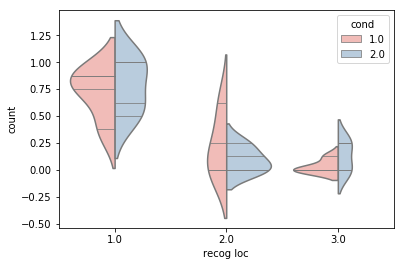

In [11]:
sns.violinplot(x="recog loc", y="count", hue='cond', split=True, inner="stick", data=recog_mean, palette="Pastel1")

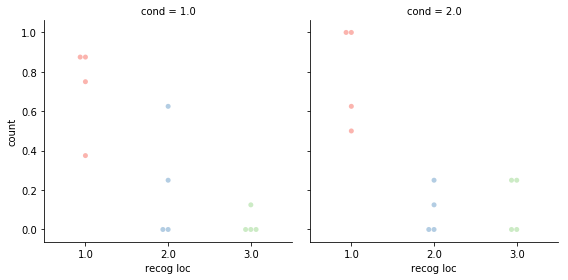

In [12]:
sns.factorplot(x="recog loc", y="count",
               col="cond", data=recog_mean, kind="swarm", palette='Pastel1');

In [13]:
# fix_dur['startloc']=fix_dur['startloc'].map({'loc1start':1, 'loc2start':2, 'loc3start':3, 'screen':4, 'offscreen':5})
fix_dur.duration=fix_dur.duration

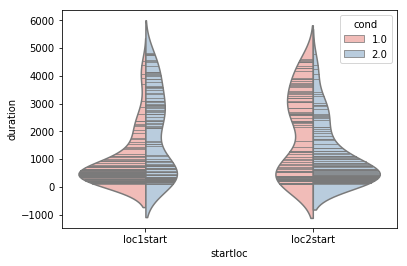

In [27]:
sns.violinplot(x="startloc", y="duration", hue='cond', split=True, inner="stick", 
               data=fix_dur[fix_dur['startloc']!='loc3start'], palette="Pastel1")

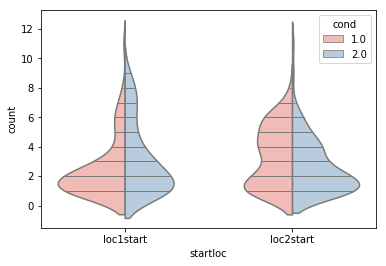

In [26]:
sns.violinplot(x="startloc", y="count", hue='cond', split=True, inner="stick", 
               data=fix_num[fix_num['startloc']!='loc3start'], palette="Pastel1")

In [31]:
mismatch_fix_dur=fix_dur[fix_dur['cond']==1]
match_fix_dur=fix_dur[fix_dur['cond']==2]

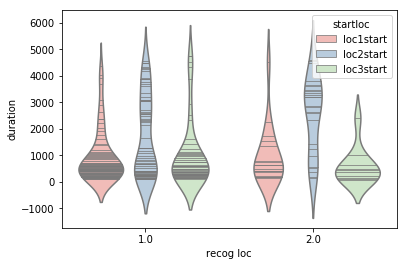

In [32]:
sns.violinplot(x="recog loc", y="duration", hue='startloc', inner="stick", 
               data=mismatch_fix_dur[mismatch_fix_dur['recog loc']<3], palette="Pastel1")

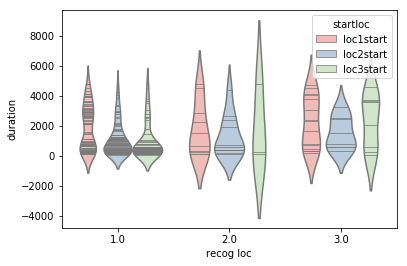

In [33]:
sns.violinplot(x="recog loc", y="duration", hue='startloc', inner="stick", 
               data=match_fix_dur, palette="Pastel1")

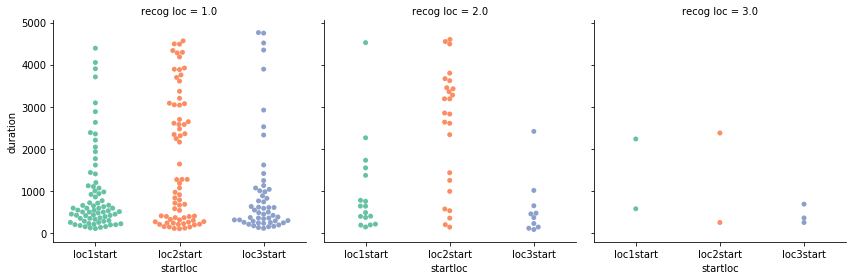

In [17]:
sns.factorplot(x="startloc", y="duration", col="recog loc", 
               data=fix_dur[fix_dur['cond']==1], kind="swarm", palette='Set2');

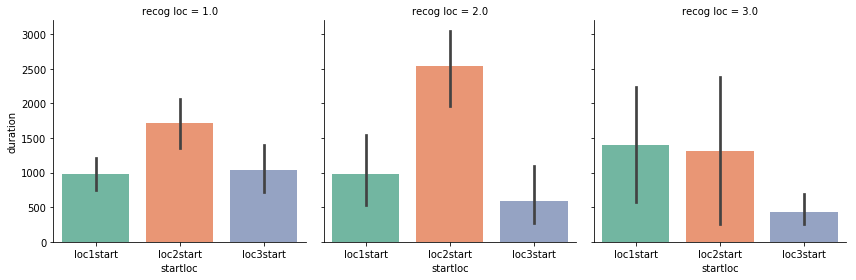

In [18]:
sns.factorplot(x="startloc", y="duration",
               col="recog loc", data=fix_dur[fix_dur['cond']==1], kind="bar", palette='Set2');

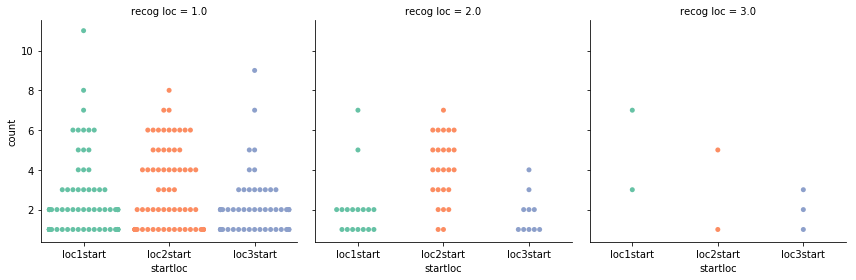

In [19]:
sns.factorplot(x="startloc", y="count",
               col="recog loc", data=fix_num[fix_num['cond']==1], kind="swarm", palette='Set2');

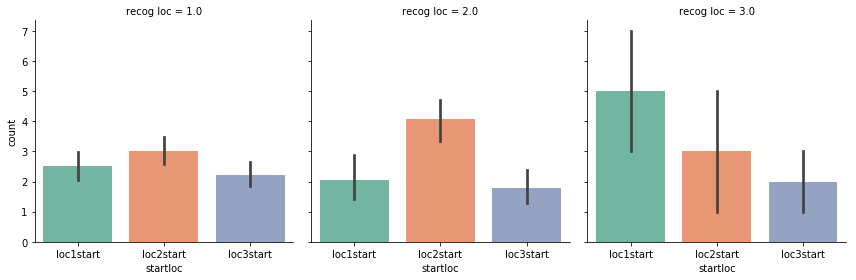

In [20]:
sns.factorplot(x="startloc", y="count",
               col="recog loc", data=fix_num[fix_num['cond']==1], kind="bar", palette='Set2');

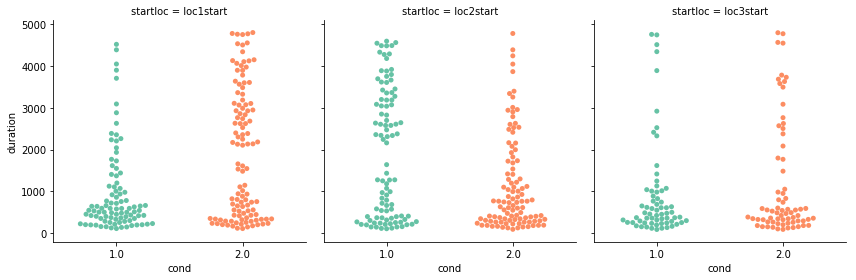

In [21]:
sns.factorplot(x="cond", y="duration",
               col="startloc", data=fix_dur, kind="swarm", palette='Set2');

In [22]:
fix_dur_sub=pd.DataFrame(fix.groupby(['sub', 'cond', 'startloc', 'recog loc'])['duration'].mean())
fix_dur_sub.reset_index(inplace=True)

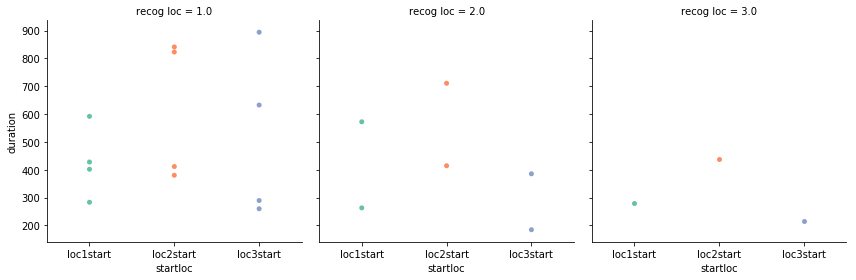

In [23]:
sns.factorplot(x="startloc", y="duration",
               col="recog loc", data=fix_dur_sub[fix_dur_sub['cond']==1], kind="swarm", palette='Set2');

In [24]:
fix_dur_sub[fix_dur_sub['cond']==1]

,sub,cond,startloc,recog loc,duration
0,ec105,1.0,loc1start,1.0,591.925926
1,ec105,1.0,loc2start,1.0,841.377049
2,ec105,1.0,loc3start,1.0,894.333333
11,ec106,1.0,loc1start,1.0,401.818182
12,ec106,1.0,loc1start,2.0,572.333333
13,ec106,1.0,loc2start,1.0,823.272727
14,ec106,1.0,loc2start,2.0,710.901408
15,ec106,1.0,loc3start,1.0,632.645161
16,ec106,1.0,loc3start,2.0,385.384615
26,ec107,1.0,loc1start,1.0,427.784615
